# GAN Training - Camel Dataset

This notebook trains a Generative Adversarial Network (GAN) on the Camel
dataset (Quick, Draw!) to generate hand-drawn camel sketches.

## Features

- **Fixed Configuration**: BATCH_SIZE=1024, EPOCHS=1500 for triage experiments
- **Seed Control**: Reproducible training with configurable random seed
- **W&B Integration**: Full experiment tracking with Weights & Biases
- **LR Scheduling**: Step decay learning rate for stable training
- **Enhanced Visualization**: Loss, accuracy, and LR history plots

## Architecture

- **Discriminator**: 4-layer CNN with strided convolutions
- **Generator**: 4-layer deconvolution network with upsampling

## References

- Goodfellow et al. "Generative Adversarial Networks" (2014)
- Chapter 4 of "Generative Deep Learning" book

## GPU Memory Setup

Configure TensorFlow to use memory growth, preventing OOM errors.

In [1]:
# =============================================================================
# GPU MEMORY CONFIGURATION
# =============================================================================
# Enable memory growth to prevent TensorFlow from allocating all GPU memory
# at once. This must be done BEFORE any other TensorFlow operations.

import tensorflow as tf

# Get list of available GPUs
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    # Enable memory growth for each GPU
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print(f"✓ GPU(s) available: {[gpu.name for gpu in gpus]}")
else:
    print("⚠ WARNING: No GPU detected, running on CPU")

2026-01-06 14:26:20.102791: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/cataluna84/Workspace-Antigravity/Generative_Deep_Learning/.venv/lib/python3.13/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


✓ GPU(s) available: ['/physical_device:GPU:0']


## Imports

Import all required modules including project utilities.

In [2]:
# =============================================================================
# IMPORTS
# =============================================================================

# -----------------------------------------------------------------------------
# Path Configuration
# -----------------------------------------------------------------------------
import sys
sys.path.insert(0, '..')      # For v1/src modules
sys.path.insert(0, '../..')   # For project root utils/

# -----------------------------------------------------------------------------
# Standard Library
# -----------------------------------------------------------------------------
import os
import random

# -----------------------------------------------------------------------------
# Third-Party Libraries
# -----------------------------------------------------------------------------
import matplotlib.pyplot as plt
import numpy as np
import wandb

# -----------------------------------------------------------------------------
# Project Modules
# -----------------------------------------------------------------------------
from src.models.GAN import GAN
from src.utils.loaders import load_safari

# GPU utilities for VRAM info and config display
from utils.gpu_utils import (
    get_gpu_vram_gb,
    print_training_config
)

## Seed Control for Reproducibility

Set random seeds to ensure reproducible experiments. Change SEED to test
different weight initializations.

In [3]:
# =============================================================================
# SEED CONTROL FOR REPRODUCIBILITY
# =============================================================================
# Control all random seeds for reproducible experiments.
# Change SEED value to test different weight initializations.

SEED = 707  # Testing with GPU resources freed

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Additional GPU determinism settings
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['PYTHONHASHSEED'] = str(SEED)

print(f"✓ Random seed set to {SEED}")
print(f"  • Python random: seeded")
print(f"  • NumPy: seeded")
print(f"  • TensorFlow: seeded")
print(f"  • TF_DETERMINISTIC_OPS: enabled")

✓ Random seed set to 707
  • Python random: seeded
  • NumPy: seeded
  • TensorFlow: seeded
  • TF_DETERMINISTIC_OPS: enabled


## Global Configuration - Part 1: Static Parameters

Run identification and reference training values.

In [4]:
# ═══════════════════════════════════════════════════════════════════
# GLOBAL CONFIGURATION - PART 1: STATIC PARAMETERS
# ═══════════════════════════════════════════════════════════════════
# These values define the experiment identity and reference baselines.
# They do not depend on GPU detection or model building.

# -----------------------------------------------------------------------------
# Run Identification
# -----------------------------------------------------------------------------
SECTION = 'gan'
RUN_ID = '0001'
DATA_NAME = 'camel'
RUN_FOLDER = f'../run/{SECTION}/{RUN_ID}_{DATA_NAME}'

# Create run directories
if not os.path.exists(RUN_FOLDER):
    os.makedirs(RUN_FOLDER)
    os.makedirs(os.path.join(RUN_FOLDER, 'viz'))
    os.makedirs(os.path.join(RUN_FOLDER, 'images'))
    os.makedirs(os.path.join(RUN_FOLDER, 'weights'))

# -----------------------------------------------------------------------------
# Reference Training Configuration
# These are the original notebook values used for epoch scaling
# -----------------------------------------------------------------------------
REFERENCE_BATCH_SIZE = 256
REFERENCE_EPOCHS = 6000
MODE = 'build'  # Options: 'build' (new training), 'load' (resume)

print(f"Run folder: {RUN_FOLDER}")
print(f"Reference batch size: {REFERENCE_BATCH_SIZE}")
print(f"Reference epochs: {REFERENCE_EPOCHS}")

Run folder: ../run/gan/0001_camel
Reference batch size: 256
Reference epochs: 6000


## Data Loading

Load the Camel dataset from Quick, Draw! collection.

In [5]:
# =============================================================================
# DATA LOADING
# =============================================================================
# Load the camel dataset from the Quick, Draw! collection
# Images are 28x28 grayscale drawings

(x_train, y_train) = load_safari(DATA_NAME)

# Print dataset information
print(f"Dataset: {DATA_NAME}")
print(f"Training samples: {x_train.shape[0]:,}")
print(f"Image dimensions: {x_train.shape[1:]}")
print(f"Data type: {x_train.dtype}")
print(f"Value range: [{x_train.min():.2f}, {x_train.max():.2f}]")

Dataset: camel
Training samples: 80,000
Image dimensions: (28, 28, 1)
Data type: float32
Value range: [-1.00, 1.00]


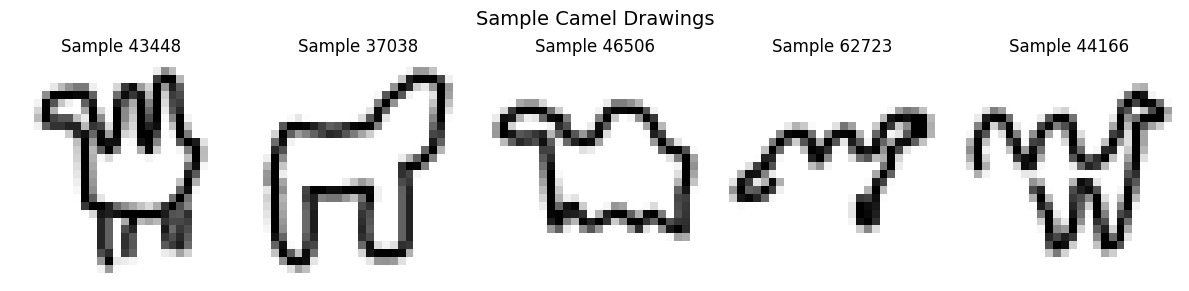

In [6]:
# =============================================================================
# SAMPLE VISUALIZATION
# =============================================================================
# Display a sample image from the dataset

fig, axes = plt.subplots(1, 5, figsize=(12, 3))
fig.suptitle('Sample Camel Drawings', fontsize=14)

for i, ax in enumerate(axes):
    idx = np.random.randint(0, x_train.shape[0])
    ax.imshow(x_train[idx, :, :, 0], cmap='gray_r')
    ax.axis('off')
    ax.set_title(f'Sample {idx}')

plt.tight_layout()
plt.show()

## Model Architecture

Build the GAN with discriminator and generator networks.

In [7]:
# =============================================================================
# MODEL ARCHITECTURE
# =============================================================================
# Build the GAN with configurable discriminator and generator
#
# Discriminator Architecture:
#   Input (28, 28, 1) → Conv layers → Flatten → Dense(1, sigmoid)
#
# Generator Architecture:
#   Input (z_dim,) → Dense → Reshape → ConvTranspose layers → Output (28, 28, 1)

gan = GAN(
    # -------------------------------------------------------------------------
    # Input Configuration
    # -------------------------------------------------------------------------
    input_dim=(28, 28, 1),  # 28x28 grayscale images
    z_dim=100,              # Latent space dimension
    
    # -------------------------------------------------------------------------
    # Discriminator Configuration
    # 4 convolutional layers with increasing filters
    # -------------------------------------------------------------------------
    discriminator_conv_filters=[64, 64, 128, 128],
    discriminator_conv_kernel_size=[5, 5, 5, 5],
    discriminator_conv_strides=[2, 2, 2, 1],
    discriminator_batch_norm_momentum=None,  # No batch norm in discriminator
    discriminator_activation='relu',
    discriminator_dropout_rate=0.4,
    discriminator_learning_rate=0.0008,
    
    # -------------------------------------------------------------------------
    # Generator Configuration
    # 4 upsampling layers to generate 28x28 output
    # -------------------------------------------------------------------------
    generator_initial_dense_layer_size=(7, 7, 64),  # Start from 7x7
    generator_upsample=[2, 2, 1, 1],  # Upsample to 14x14, then 28x28
    generator_conv_filters=[128, 64, 64, 1],
    generator_conv_kernel_size=[5, 5, 5, 5],
    generator_conv_strides=[1, 1, 1, 1],
    generator_batch_norm_momentum=0.9,
    generator_activation='relu',
    generator_dropout_rate=None,  # No dropout in generator
    generator_learning_rate=0.0004,
    
    # -------------------------------------------------------------------------
    # Optimizer
    # -------------------------------------------------------------------------
    optimiser='rmsprop'  # RMSprop works well for GANs
)

print("✓ GAN model built successfully")

I0000 00:00:1767709599.016429   44307 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6094 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5


✓ GAN model built successfully


## Global Configuration - Part 2: Fixed Batch Size

Fixed batch size for triage experiments. No dynamic allocation.

In [8]:
# ═══════════════════════════════════════════════════════════════════
# GLOBAL CONFIGURATION - PART 2: FIXED BATCH SIZE
# ═══════════════════════════════════════════════════════════════════
# Fixed batch size for triage experiments (no dynamic allocation).
# This allows controlled experiments to isolate batch size vs initialization.

# Fixed training configuration
BATCH_SIZE = 512  # Fixed for triage experiments
EPOCHS = 1500      # Scaled from reference: 6000 * (256/1024) = 1500

# Checkpoint frequency (scaled proportionally)
PRINT_EVERY_N_BATCHES = 13  # Scaled from reference: 50 * (256/1024) ≈ 13

# Get VRAM for logging purposes only
GPU_VRAM_GB = get_gpu_vram_gb()

# Print configuration summary
print_training_config(
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    model_params=gan.generator.count_params() + gan.discriminator.count_params(),
    reference_batch=REFERENCE_BATCH_SIZE,
    reference_epochs=REFERENCE_EPOCHS,
    vram_gb=GPU_VRAM_GB
)

════════════════════════════════════════════════════════════════
TRAINING CONFIGURATION
════════════════════════════════════════════════════════════════
GPU VRAM:       8 GB
Model Params:   1,564,994
Batch Size:     512 (reference: 256)
Epochs:         1500 (reference: 6000)
Scale Factor:   0.25x epochs
════════════════════════════════════════════════════════════════


## Global Configuration - Part 3: LR Scheduler

Configure step decay learning rate for stable GAN training.

In [9]:
# ═══════════════════════════════════════════════════════════════════
# GLOBAL CONFIGURATION - PART 3: LR SCHEDULER
# ═══════════════════════════════════════════════════════════════════
# Step decay: Reduce LR at fixed intervals for stable late-stage training

LR_DECAY_FACTOR = 0.5  # Multiply LR by 0.5 at each decay point
LR_DECAY_EPOCHS = EPOCHS // 4  # Decay 4 times during training

print(f"LR Decay: ×{LR_DECAY_FACTOR} every {LR_DECAY_EPOCHS} epochs")
print(f"Checkpoints: Every {PRINT_EVERY_N_BATCHES} epochs")

LR Decay: ×0.5 every 375 epochs
Checkpoints: Every 13 epochs


In [10]:
# =============================================================================
# DISCRIMINATOR ARCHITECTURE
# =============================================================================
gan.discriminator.summary()

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ discriminator_input             │ (None, 28, 28, 1)      │             0 │
│ (InputLayer)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ discriminator_conv_0 (Conv2D)   │ (None, 14, 14, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ discriminator_conv_1 (Conv2D)   │ (None, 7, 7, 64)       │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ discriminator_conv_2 (Conv2D)   │ (None, 4, 4, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ discriminator_conv_3 (Conv2D)   │ (None, 4, 4, 128)      │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 720,833 (2.75 MB)

 Trainable params: 720,833 (2.75 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# =============================================================================
# GENERATOR ARCHITECTURE
# =============================================================================
gan.generator.summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ generator_input (InputLayer)    │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3136)           │       316,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 3136)           │        12,544 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ generator_conv_0 (Conv2D)       │ (None, 14, 14, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ generator_conv_1 (Conv2D)       │ (None, 28, 28, 64)     │       204,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ generator_conv_2                │ (None, 28, 28, 64)     │       102,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ generator_conv_3                │ (None, 28, 28, 1)      │         1,601 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 28, 28, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 844,161 (3.22 MB)

 Trainable params: 837,377 (3.19 MB)

 Non-trainable params: 6,784 (26.50 KB)

## W&B Initialization

Initialize Weights & Biases for experiment tracking.

In [12]:
# =============================================================================
# W&B INITIALIZATION
# =============================================================================
# Initialize Weights & Biases for experiment tracking
# This logs all training metrics, sample images, and hyperparameters

wandb.init(
    project="generative-deep-learning",
    name=f"gan-{DATA_NAME}-bs{BATCH_SIZE}-seed{SEED}",
    config={
        # Model Configuration
        "model": "GAN",
        "dataset": DATA_NAME,
        "input_dim": gan.input_dim,
        "z_dim": gan.z_dim,
        
        # Training Configuration
        "batch_size": BATCH_SIZE,
        "seed": SEED,
        "epochs": EPOCHS,
        "reference_batch_size": REFERENCE_BATCH_SIZE,
        "reference_epochs": REFERENCE_EPOCHS,
        
        # Optimizer Configuration
        "discriminator_lr": gan.discriminator_learning_rate,
        "generator_lr": gan.generator_learning_rate,
        "optimizer": gan.optimiser,
        
        # LR Scheduler Configuration
        "lr_decay_factor": LR_DECAY_FACTOR,
        "lr_decay_epochs": LR_DECAY_EPOCHS,
        
        # Environment
        "gpu_vram_gb": GPU_VRAM_GB,
    }
)

print("✓ W&B initialized")
print(f"  Project: generative-deep-learning")
print(f"  Run: gan-{DATA_NAME}-bs{BATCH_SIZE}")
print(f"  URL: {wandb.run.url}")

wandb: Currently logged in as: cataluna84 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


✓ W&B initialized
  Project: generative-deep-learning
  Run: gan-camel-bs512
  URL: https://wandb.ai/cataluna84/generative-deep-learning/runs/brzdilqv


## Training

Train the GAN with W&B logging and LR scheduling enabled.

In [13]:
# =============================================================================
# TRAINING
# =============================================================================
# Train the GAN with:
# - W&B logging for all metrics
# - Step decay LR scheduler
# - Periodic weight saving and sample generation

gan.train(
    x_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    run_folder=RUN_FOLDER,
    print_every_n_batches=PRINT_EVERY_N_BATCHES,
    use_wandb=True,           # Enable W&B logging
    lr_decay_factor=LR_DECAY_FACTOR,
    lr_decay_epochs=LR_DECAY_EPOCHS
)

2026-01-06 14:26:47.708024: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91701
E0000 00:00:1767709612.008436   44307 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


0 [D loss: (0.697)(R 0.693, F 0.702)] [D acc: (0.396)(0.527, 0.264)] [G loss: 0.672] [G acc: 1.000]


2026-01-06 14:27:01.019869: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


1 [D loss: (0.703)(R 0.647, F 0.759)] [D acc: (0.445)(0.509, 0.382)] [G loss: 0.617] [G acc: 1.000]
2 [D loss: (0.761)(R 0.641, F 0.880)] [D acc: (0.463)(0.505, 0.421)] [G loss: 0.557] [G acc: 1.000]
3 [D loss: (0.780)(R 0.774, F 0.787)] [D acc: (0.472)(0.504, 0.441)] [G loss: 0.433] [G acc: 1.000]
4 [D loss: (0.718)(R 0.701, F 0.734)] [D acc: (0.478)(0.503, 0.453)] [G loss: 0.361] [G acc: 1.000]
5 [D loss: (0.689)(R 0.669, F 0.708)] [D acc: (0.482)(0.502, 0.461)] [G loss: 0.326] [G acc: 1.000]
6 [D loss: (0.677)(R 0.656, F 0.698)] [D acc: (0.484)(0.502, 0.466)] [G loss: 0.317] [G acc: 1.000]
7 [D loss: (0.677)(R 0.657, F 0.697)] [D acc: (0.486)(0.502, 0.470)] [G loss: 0.321] [G acc: 1.000]
8 [D loss: (0.680)(R 0.663, F 0.697)] [D acc: (0.488)(0.502, 0.474)] [G loss: 0.329] [G acc: 1.000]
9 [D loss: (0.683)(R 0.669, F 0.697)] [D acc: (0.489)(0.501, 0.476)] [G loss: 0.340] [G acc: 1.000]
10 [D loss: (0.684)(R 0.672, F 0.696)] [D acc: (0.490)(0.501, 0.479)] [G loss: 0.352] [G acc: 1.000]

2026-01-06 14:27:14.960722: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


14 [D loss: (0.664)(R 0.660, F 0.669)] [D acc: (0.493)(0.501, 0.484)] [G loss: 0.408] [G acc: 1.000]
15 [D loss: (0.654)(R 0.650, F 0.657)] [D acc: (0.493)(0.501, 0.485)] [G loss: 0.421] [G acc: 1.000]
16 [D loss: (0.641)(R 0.639, F 0.644)] [D acc: (0.493)(0.501, 0.486)] [G loss: 0.435] [G acc: 1.000]
17 [D loss: (0.629)(R 0.626, F 0.631)] [D acc: (0.494)(0.501, 0.487)] [G loss: 0.448] [G acc: 1.000]
18 [D loss: (0.616)(R 0.614, F 0.618)] [D acc: (0.494)(0.501, 0.488)] [G loss: 0.460] [G acc: 1.000]
19 [D loss: (0.604)(R 0.602, F 0.605)] [D acc: (0.494)(0.501, 0.488)] [G loss: 0.471] [G acc: 1.000]
20 [D loss: (0.592)(R 0.591, F 0.593)] [D acc: (0.495)(0.501, 0.489)] [G loss: 0.482] [G acc: 0.982]
21 [D loss: (0.581)(R 0.580, F 0.583)] [D acc: (0.495)(0.501, 0.490)] [G loss: 0.492] [G acc: 0.944]
22 [D loss: (0.571)(R 0.570, F 0.572)] [D acc: (0.501)(0.501, 0.501)] [G loss: 0.500] [G acc: 0.903]
23 [D loss: (0.562)(R 0.560, F 0.563)] [D acc: (0.515)(0.512, 0.519)] [G loss: 0.509] [G ac

2026-01-06 14:27:26.817536: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


27 [D loss: (0.531)(R 0.529, F 0.532)] [D acc: (0.584)(0.580, 0.588)] [G loss: 0.536] [G acc: 0.741]
28 [D loss: (0.524)(R 0.523, F 0.526)] [D acc: (0.599)(0.595, 0.602)] [G loss: 0.541] [G acc: 0.716]
29 [D loss: (0.518)(R 0.517, F 0.519)] [D acc: (0.612)(0.609, 0.615)] [G loss: 0.547] [G acc: 0.692]
30 [D loss: (0.512)(R 0.511, F 0.514)] [D acc: (0.625)(0.622, 0.628)] [G loss: 0.552] [G acc: 0.670]
31 [D loss: (0.507)(R 0.506, F 0.509)] [D acc: (0.636)(0.634, 0.639)] [G loss: 0.556] [G acc: 0.649]
32 [D loss: (0.502)(R 0.501, F 0.504)] [D acc: (0.648)(0.645, 0.650)] [G loss: 0.561] [G acc: 0.629]
33 [D loss: (0.497)(R 0.496, F 0.499)] [D acc: (0.658)(0.655, 0.661)] [G loss: 0.565] [G acc: 0.611]
34 [D loss: (0.493)(R 0.492, F 0.494)] [D acc: (0.668)(0.665, 0.670)] [G loss: 0.569] [G acc: 0.593]
35 [D loss: (0.489)(R 0.487, F 0.490)] [D acc: (0.677)(0.675, 0.679)] [G loss: 0.572] [G acc: 0.577]
36 [D loss: (0.485)(R 0.483, F 0.486)] [D acc: (0.686)(0.684, 0.688)] [G loss: 0.576] [G ac

2026-01-06 14:27:37.021636: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


40 [D loss: (0.471)(R 0.469, F 0.472)] [D acc: (0.717)(0.715, 0.718)] [G loss: 0.588] [G acc: 0.506]
41 [D loss: (0.468)(R 0.466, F 0.469)] [D acc: (0.724)(0.722, 0.725)] [G loss: 0.591] [G acc: 0.494]
42 [D loss: (0.465)(R 0.463, F 0.466)] [D acc: (0.730)(0.728, 0.732)] [G loss: 0.594] [G acc: 0.483]
43 [D loss: (0.462)(R 0.461, F 0.463)] [D acc: (0.736)(0.735, 0.738)] [G loss: 0.597] [G acc: 0.472]
44 [D loss: (0.459)(R 0.458, F 0.460)] [D acc: (0.742)(0.741, 0.744)] [G loss: 0.599] [G acc: 0.461]
45 [D loss: (0.456)(R 0.455, F 0.458)] [D acc: (0.748)(0.746, 0.749)] [G loss: 0.602] [G acc: 0.451]
46 [D loss: (0.454)(R 0.453, F 0.455)] [D acc: (0.753)(0.752, 0.754)] [G loss: 0.604] [G acc: 0.442]
47 [D loss: (0.454)(R 0.450, F 0.457)] [D acc: (0.753)(0.757, 0.749)] [G loss: 0.606] [G acc: 0.433]
48 [D loss: (0.456)(R 0.454, F 0.457)] [D acc: (0.753)(0.752, 0.754)] [G loss: 0.609] [G acc: 0.424]
49 [D loss: (0.453)(R 0.452, F 0.454)] [D acc: (0.758)(0.757, 0.759)] [G loss: 0.611] [G ac

2026-01-06 14:27:46.290959: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


53 [D loss: (0.445)(R 0.444, F 0.446)] [D acc: (0.776)(0.775, 0.777)] [G loss: 0.619] [G acc: 0.384]
54 [D loss: (0.443)(R 0.442, F 0.444)] [D acc: (0.780)(0.779, 0.781)] [G loss: 0.620] [G acc: 0.377]
55 [D loss: (0.441)(R 0.440, F 0.442)] [D acc: (0.784)(0.783, 0.785)] [G loss: 0.622] [G acc: 0.371]
56 [D loss: (0.439)(R 0.438, F 0.440)] [D acc: (0.788)(0.787, 0.789)] [G loss: 0.624] [G acc: 0.364]
57 [D loss: (0.437)(R 0.436, F 0.438)] [D acc: (0.791)(0.791, 0.792)] [G loss: 0.626] [G acc: 0.358]
58 [D loss: (0.435)(R 0.434, F 0.436)] [D acc: (0.795)(0.794, 0.796)] [G loss: 0.628] [G acc: 0.352]
59 [D loss: (0.434)(R 0.433, F 0.434)] [D acc: (0.798)(0.798, 0.799)] [G loss: 0.630] [G acc: 0.346]
60 [D loss: (0.432)(R 0.431, F 0.433)] [D acc: (0.802)(0.801, 0.803)] [G loss: 0.632] [G acc: 0.340]
61 [D loss: (0.430)(R 0.429, F 0.431)] [D acc: (0.805)(0.804, 0.806)] [G loss: 0.634] [G acc: 0.335]
62 [D loss: (0.428)(R 0.427, F 0.429)] [D acc: (0.808)(0.807, 0.809)] [G loss: 0.636] [G ac

2026-01-06 14:27:55.337984: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


66 [D loss: (0.422)(R 0.421, F 0.422)] [D acc: (0.820)(0.819, 0.820)] [G loss: 0.646] [G acc: 0.310]
67 [D loss: (0.420)(R 0.419, F 0.421)] [D acc: (0.822)(0.822, 0.823)] [G loss: 0.649] [G acc: 0.305]
68 [D loss: (0.418)(R 0.417, F 0.419)] [D acc: (0.825)(0.824, 0.825)] [G loss: 0.652] [G acc: 0.301]
69 [D loss: (0.417)(R 0.416, F 0.419)] [D acc: (0.824)(0.827, 0.821)] [G loss: 0.656] [G acc: 0.297]
70 [D loss: (0.419)(R 0.418, F 0.419)] [D acc: (0.823)(0.823, 0.824)] [G loss: 0.658] [G acc: 0.292]
71 [D loss: (0.417)(R 0.416, F 0.417)] [D acc: (0.826)(0.825, 0.826)] [G loss: 0.661] [G acc: 0.288]
72 [D loss: (0.415)(R 0.415, F 0.416)] [D acc: (0.828)(0.828, 0.829)] [G loss: 0.664] [G acc: 0.284]
73 [D loss: (0.413)(R 0.413, F 0.414)] [D acc: (0.830)(0.830, 0.831)] [G loss: 0.668] [G acc: 0.281]
74 [D loss: (0.411)(R 0.411, F 0.412)] [D acc: (0.833)(0.832, 0.833)] [G loss: 0.672] [G acc: 0.277]
75 [D loss: (0.409)(R 0.409, F 0.410)] [D acc: (0.835)(0.834, 0.836)] [G loss: 0.676] [G ac

2026-01-06 14:28:06.971726: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


79 [D loss: (0.401)(R 0.401, F 0.401)] [D acc: (0.843)(0.843, 0.844)] [G loss: 0.710] [G acc: 0.260]
80 [D loss: (0.399)(R 0.399, F 0.399)] [D acc: (0.845)(0.845, 0.846)] [G loss: 0.717] [G acc: 0.256]
81 [D loss: (0.396)(R 0.396, F 0.396)] [D acc: (0.847)(0.847, 0.848)] [G loss: 0.724] [G acc: 0.253]
82 [D loss: (0.394)(R 0.394, F 0.394)] [D acc: (0.849)(0.848, 0.849)] [G loss: 0.733] [G acc: 0.250]
83 [D loss: (0.391)(R 0.392, F 0.391)] [D acc: (0.851)(0.850, 0.851)] [G loss: 0.743] [G acc: 0.247]
84 [D loss: (0.389)(R 0.389, F 0.388)] [D acc: (0.852)(0.852, 0.853)] [G loss: 0.756] [G acc: 0.244]
85 [D loss: (0.386)(R 0.386, F 0.385)] [D acc: (0.854)(0.854, 0.855)] [G loss: 0.771] [G acc: 0.241]
86 [D loss: (0.383)(R 0.383, F 0.382)] [D acc: (0.856)(0.855, 0.856)] [G loss: 0.788] [G acc: 0.239]
87 [D loss: (0.379)(R 0.380, F 0.379)] [D acc: (0.858)(0.857, 0.858)] [G loss: 0.808] [G acc: 0.236]
88 [D loss: (0.377)(R 0.377, F 0.377)] [D acc: (0.859)(0.859, 0.859)] [G loss: 0.830] [G ac

2026-01-06 14:28:17.684742: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


92 [D loss: (0.728)(R 0.715, F 0.741)] [D acc: (0.844)(0.846, 0.842)] [G loss: 0.814] [G acc: 0.260]
93 [D loss: (0.748)(R 0.737, F 0.759)] [D acc: (0.840)(0.843, 0.838)] [G loss: 0.811] [G acc: 0.268]
94 [D loss: (0.763)(R 0.755, F 0.770)] [D acc: (0.837)(0.839, 0.835)] [G loss: 0.809] [G acc: 0.271]
95 [D loss: (0.772)(R 0.767, F 0.777)] [D acc: (0.833)(0.835, 0.831)] [G loss: 0.808] [G acc: 0.272]
96 [D loss: (0.778)(R 0.774, F 0.781)] [D acc: (0.830)(0.832, 0.828)] [G loss: 0.808] [G acc: 0.272]
97 [D loss: (0.781)(R 0.779, F 0.784)] [D acc: (0.826)(0.828, 0.824)] [G loss: 0.807] [G acc: 0.273]
98 [D loss: (0.784)(R 0.782, F 0.786)] [D acc: (0.823)(0.825, 0.821)] [G loss: 0.806] [G acc: 0.274]
99 [D loss: (0.785)(R 0.784, F 0.787)] [D acc: (0.819)(0.821, 0.817)] [G loss: 0.804] [G acc: 0.276]
100 [D loss: (0.787)(R 0.785, F 0.788)] [D acc: (0.816)(0.818, 0.814)] [G loss: 0.803] [G acc: 0.278]
101 [D loss: (0.788)(R 0.787, F 0.789)] [D acc: (0.813)(0.815, 0.811)] [G loss: 0.802] [G 

2026-01-06 14:28:28.901263: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


105 [D loss: (0.790)(R 0.790, F 0.791)] [D acc: (0.800)(0.802, 0.799)] [G loss: 0.797] [G acc: 0.291]
106 [D loss: (0.791)(R 0.790, F 0.791)] [D acc: (0.798)(0.799, 0.796)] [G loss: 0.796] [G acc: 0.295]
107 [D loss: (0.791)(R 0.790, F 0.791)] [D acc: (0.795)(0.797, 0.793)] [G loss: 0.795] [G acc: 0.299]
108 [D loss: (0.791)(R 0.790, F 0.791)] [D acc: (0.792)(0.794, 0.790)] [G loss: 0.794] [G acc: 0.303]
109 [D loss: (0.791)(R 0.790, F 0.791)] [D acc: (0.789)(0.791, 0.787)] [G loss: 0.793] [G acc: 0.307]
110 [D loss: (0.791)(R 0.790, F 0.791)] [D acc: (0.787)(0.788, 0.785)] [G loss: 0.792] [G acc: 0.311]
111 [D loss: (0.790)(R 0.790, F 0.791)] [D acc: (0.784)(0.786, 0.782)] [G loss: 0.791] [G acc: 0.315]
112 [D loss: (0.790)(R 0.790, F 0.790)] [D acc: (0.781)(0.783, 0.780)] [G loss: 0.789] [G acc: 0.319]
113 [D loss: (0.790)(R 0.789, F 0.790)] [D acc: (0.779)(0.781, 0.777)] [G loss: 0.788] [G acc: 0.323]
114 [D loss: (0.789)(R 0.789, F 0.790)] [D acc: (0.777)(0.778, 0.775)] [G loss: 0.

2026-01-06 14:28:39.610384: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


118 [D loss: (0.787)(R 0.787, F 0.788)] [D acc: (0.767)(0.769, 0.766)] [G loss: 0.783] [G acc: 0.344]
119 [D loss: (0.787)(R 0.787, F 0.787)] [D acc: (0.765)(0.767, 0.763)] [G loss: 0.782] [G acc: 0.349]
120 [D loss: (0.787)(R 0.786, F 0.787)] [D acc: (0.763)(0.764, 0.761)] [G loss: 0.781] [G acc: 0.353]
121 [D loss: (0.786)(R 0.786, F 0.786)] [D acc: (0.761)(0.762, 0.759)] [G loss: 0.780] [G acc: 0.357]
122 [D loss: (0.786)(R 0.785, F 0.786)] [D acc: (0.758)(0.760, 0.757)] [G loss: 0.779] [G acc: 0.362]
123 [D loss: (0.785)(R 0.785, F 0.786)] [D acc: (0.756)(0.758, 0.755)] [G loss: 0.778] [G acc: 0.367]
124 [D loss: (0.785)(R 0.785, F 0.785)] [D acc: (0.754)(0.756, 0.753)] [G loss: 0.777] [G acc: 0.371]
125 [D loss: (0.785)(R 0.784, F 0.785)] [D acc: (0.752)(0.754, 0.751)] [G loss: 0.776] [G acc: 0.376]
126 [D loss: (0.784)(R 0.784, F 0.784)] [D acc: (0.750)(0.752, 0.749)] [G loss: 0.775] [G acc: 0.380]
127 [D loss: (0.784)(R 0.784, F 0.784)] [D acc: (0.748)(0.750, 0.747)] [G loss: 0.

2026-01-06 14:28:51.391404: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


131 [D loss: (0.782)(R 0.782, F 0.783)] [D acc: (0.741)(0.742, 0.739)] [G loss: 0.769] [G acc: 0.402]
132 [D loss: (0.782)(R 0.782, F 0.782)] [D acc: (0.739)(0.740, 0.738)] [G loss: 0.768] [G acc: 0.407]
133 [D loss: (0.782)(R 0.781, F 0.783)] [D acc: (0.737)(0.739, 0.736)] [G loss: 0.767] [G acc: 0.411]
134 [D loss: (0.783)(R 0.783, F 0.783)] [D acc: (0.735)(0.737, 0.734)] [G loss: 0.766] [G acc: 0.415]
135 [D loss: (0.783)(R 0.783, F 0.783)] [D acc: (0.734)(0.735, 0.732)] [G loss: 0.765] [G acc: 0.419]
136 [D loss: (0.782)(R 0.782, F 0.783)] [D acc: (0.732)(0.733, 0.731)] [G loss: 0.764] [G acc: 0.423]
137 [D loss: (0.782)(R 0.782, F 0.782)] [D acc: (0.730)(0.732, 0.729)] [G loss: 0.763] [G acc: 0.427]
138 [D loss: (0.782)(R 0.782, F 0.782)] [D acc: (0.729)(0.730, 0.727)] [G loss: 0.761] [G acc: 0.431]
139 [D loss: (0.782)(R 0.781, F 0.782)] [D acc: (0.727)(0.728, 0.726)] [G loss: 0.760] [G acc: 0.435]
140 [D loss: (0.782)(R 0.781, F 0.782)] [D acc: (0.725)(0.727, 0.724)] [G loss: 0.

2026-01-06 14:29:03.001857: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


144 [D loss: (0.781)(R 0.781, F 0.781)] [D acc: (0.719)(0.720, 0.718)] [G loss: 0.754] [G acc: 0.455]
145 [D loss: (0.781)(R 0.781, F 0.781)] [D acc: (0.717)(0.719, 0.716)] [G loss: 0.753] [G acc: 0.458]
146 [D loss: (0.781)(R 0.780, F 0.781)] [D acc: (0.716)(0.717, 0.715)] [G loss: 0.752] [G acc: 0.462]
147 [D loss: (0.780)(R 0.780, F 0.781)] [D acc: (0.714)(0.716, 0.713)] [G loss: 0.751] [G acc: 0.465]
148 [D loss: (0.780)(R 0.780, F 0.780)] [D acc: (0.713)(0.714, 0.712)] [G loss: 0.750] [G acc: 0.469]
149 [D loss: (0.780)(R 0.780, F 0.780)] [D acc: (0.712)(0.713, 0.710)] [G loss: 0.749] [G acc: 0.472]
150 [D loss: (0.780)(R 0.779, F 0.780)] [D acc: (0.710)(0.711, 0.709)] [G loss: 0.748] [G acc: 0.476]
151 [D loss: (0.779)(R 0.779, F 0.780)] [D acc: (0.709)(0.710, 0.708)] [G loss: 0.747] [G acc: 0.479]
152 [D loss: (0.779)(R 0.779, F 0.779)] [D acc: (0.707)(0.709, 0.706)] [G loss: 0.747] [G acc: 0.482]
153 [D loss: (0.779)(R 0.779, F 0.779)] [D acc: (0.706)(0.707, 0.705)] [G loss: 0.

2026-01-06 14:29:14.274845: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


157 [D loss: (0.778)(R 0.778, F 0.778)] [D acc: (0.701)(0.702, 0.700)] [G loss: 0.742] [G acc: 0.498]
158 [D loss: (0.777)(R 0.777, F 0.778)] [D acc: (0.700)(0.701, 0.698)] [G loss: 0.742] [G acc: 0.501]
159 [D loss: (0.777)(R 0.777, F 0.777)] [D acc: (0.698)(0.699, 0.697)] [G loss: 0.741] [G acc: 0.504]
160 [D loss: (0.777)(R 0.777, F 0.777)] [D acc: (0.697)(0.698, 0.696)] [G loss: 0.740] [G acc: 0.507]
161 [D loss: (0.776)(R 0.776, F 0.777)] [D acc: (0.696)(0.697, 0.695)] [G loss: 0.739] [G acc: 0.510]
162 [D loss: (0.776)(R 0.776, F 0.776)] [D acc: (0.695)(0.696, 0.694)] [G loss: 0.739] [G acc: 0.513]
163 [D loss: (0.776)(R 0.776, F 0.776)] [D acc: (0.693)(0.694, 0.692)] [G loss: 0.738] [G acc: 0.516]
164 [D loss: (0.775)(R 0.775, F 0.776)] [D acc: (0.692)(0.693, 0.691)] [G loss: 0.737] [G acc: 0.518]
165 [D loss: (0.775)(R 0.775, F 0.775)] [D acc: (0.691)(0.692, 0.690)] [G loss: 0.736] [G acc: 0.521]
166 [D loss: (0.775)(R 0.775, F 0.775)] [D acc: (0.690)(0.691, 0.689)] [G loss: 0.

2026-01-06 14:29:24.038406: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


170 [D loss: (0.774)(R 0.774, F 0.774)] [D acc: (0.685)(0.686, 0.684)] [G loss: 0.733] [G acc: 0.535]
171 [D loss: (0.774)(R 0.773, F 0.774)] [D acc: (0.684)(0.685, 0.683)] [G loss: 0.732] [G acc: 0.537]
172 [D loss: (0.773)(R 0.773, F 0.774)] [D acc: (0.683)(0.684, 0.682)] [G loss: 0.731] [G acc: 0.540]
173 [D loss: (0.773)(R 0.773, F 0.773)] [D acc: (0.682)(0.683, 0.681)] [G loss: 0.731] [G acc: 0.543]
174 [D loss: (0.773)(R 0.773, F 0.773)] [D acc: (0.681)(0.682, 0.680)] [G loss: 0.730] [G acc: 0.545]
175 [D loss: (0.773)(R 0.773, F 0.773)] [D acc: (0.680)(0.681, 0.679)] [G loss: 0.730] [G acc: 0.548]
176 [D loss: (0.773)(R 0.772, F 0.773)] [D acc: (0.679)(0.680, 0.678)] [G loss: 0.729] [G acc: 0.550]
177 [D loss: (0.772)(R 0.772, F 0.772)] [D acc: (0.678)(0.679, 0.677)] [G loss: 0.728] [G acc: 0.552]
178 [D loss: (0.772)(R 0.772, F 0.772)] [D acc: (0.677)(0.678, 0.676)] [G loss: 0.728] [G acc: 0.555]
179 [D loss: (0.772)(R 0.772, F 0.772)] [D acc: (0.676)(0.677, 0.675)] [G loss: 0.

2026-01-06 14:29:33.788606: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


183 [D loss: (0.771)(R 0.770, F 0.771)] [D acc: (0.672)(0.673, 0.671)] [G loss: 0.726] [G acc: 0.566]
184 [D loss: (0.770)(R 0.770, F 0.770)] [D acc: (0.671)(0.672, 0.670)] [G loss: 0.725] [G acc: 0.568]
185 [D loss: (0.770)(R 0.770, F 0.770)] [D acc: (0.670)(0.671, 0.669)] [G loss: 0.725] [G acc: 0.570]
186 [D loss: (0.770)(R 0.770, F 0.770)] [D acc: (0.669)(0.670, 0.669)] [G loss: 0.724] [G acc: 0.572]
187 [D loss: (0.769)(R 0.769, F 0.770)] [D acc: (0.669)(0.669, 0.668)] [G loss: 0.724] [G acc: 0.574]
188 [D loss: (0.769)(R 0.769, F 0.769)] [D acc: (0.668)(0.669, 0.667)] [G loss: 0.723] [G acc: 0.576]
189 [D loss: (0.769)(R 0.769, F 0.769)] [D acc: (0.667)(0.668, 0.666)] [G loss: 0.723] [G acc: 0.579]
190 [D loss: (0.769)(R 0.768, F 0.769)] [D acc: (0.666)(0.667, 0.665)] [G loss: 0.723] [G acc: 0.581]
191 [D loss: (0.768)(R 0.768, F 0.768)] [D acc: (0.665)(0.666, 0.664)] [G loss: 0.722] [G acc: 0.583]
192 [D loss: (0.768)(R 0.768, F 0.768)] [D acc: (0.664)(0.665, 0.663)] [G loss: 0.

2026-01-06 14:29:42.691063: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


196 [D loss: (0.768)(R 0.767, F 0.768)] [D acc: (0.661)(0.662, 0.660)] [G loss: 0.719] [G acc: 0.593]
197 [D loss: (0.768)(R 0.767, F 0.768)] [D acc: (0.660)(0.661, 0.659)] [G loss: 0.718] [G acc: 0.595]
198 [D loss: (0.767)(R 0.767, F 0.768)] [D acc: (0.659)(0.660, 0.658)] [G loss: 0.718] [G acc: 0.597]
199 [D loss: (0.767)(R 0.767, F 0.767)] [D acc: (0.658)(0.659, 0.657)] [G loss: 0.717] [G acc: 0.599]
200 [D loss: (0.767)(R 0.767, F 0.767)] [D acc: (0.657)(0.658, 0.657)] [G loss: 0.717] [G acc: 0.601]
201 [D loss: (0.767)(R 0.767, F 0.767)] [D acc: (0.657)(0.657, 0.656)] [G loss: 0.716] [G acc: 0.603]
202 [D loss: (0.767)(R 0.767, F 0.767)] [D acc: (0.656)(0.657, 0.655)] [G loss: 0.716] [G acc: 0.605]
203 [D loss: (0.767)(R 0.766, F 0.767)] [D acc: (0.655)(0.656, 0.654)] [G loss: 0.715] [G acc: 0.607]
204 [D loss: (0.766)(R 0.766, F 0.766)] [D acc: (0.654)(0.655, 0.654)] [G loss: 0.715] [G acc: 0.608]
205 [D loss: (0.766)(R 0.766, F 0.766)] [D acc: (0.654)(0.654, 0.653)] [G loss: 0.

2026-01-06 14:29:51.840329: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


209 [D loss: (0.765)(R 0.765, F 0.765)] [D acc: (0.651)(0.651, 0.650)] [G loss: 0.712] [G acc: 0.617]
210 [D loss: (0.765)(R 0.765, F 0.765)] [D acc: (0.650)(0.651, 0.649)] [G loss: 0.712] [G acc: 0.619]
211 [D loss: (0.765)(R 0.765, F 0.765)] [D acc: (0.649)(0.650, 0.648)] [G loss: 0.711] [G acc: 0.621]
212 [D loss: (0.765)(R 0.765, F 0.765)] [D acc: (0.648)(0.649, 0.648)] [G loss: 0.711] [G acc: 0.623]
213 [D loss: (0.765)(R 0.764, F 0.765)] [D acc: (0.648)(0.649, 0.647)] [G loss: 0.710] [G acc: 0.624]
214 [D loss: (0.764)(R 0.764, F 0.764)] [D acc: (0.647)(0.648, 0.646)] [G loss: 0.710] [G acc: 0.626]
215 [D loss: (0.764)(R 0.764, F 0.764)] [D acc: (0.646)(0.647, 0.646)] [G loss: 0.709] [G acc: 0.628]
216 [D loss: (0.764)(R 0.764, F 0.764)] [D acc: (0.646)(0.647, 0.645)] [G loss: 0.709] [G acc: 0.629]
217 [D loss: (0.764)(R 0.764, F 0.764)] [D acc: (0.645)(0.646, 0.644)] [G loss: 0.708] [G acc: 0.631]
218 [D loss: (0.763)(R 0.763, F 0.764)] [D acc: (0.644)(0.645, 0.644)] [G loss: 0.

2026-01-06 14:30:00.995383: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


222 [D loss: (0.762)(R 0.762, F 0.763)] [D acc: (0.642)(0.643, 0.641)] [G loss: 0.706] [G acc: 0.639]
223 [D loss: (0.762)(R 0.762, F 0.762)] [D acc: (0.641)(0.642, 0.641)] [G loss: 0.706] [G acc: 0.641]
224 [D loss: (0.762)(R 0.762, F 0.762)] [D acc: (0.641)(0.641, 0.640)] [G loss: 0.705] [G acc: 0.642]
225 [D loss: (0.761)(R 0.761, F 0.762)] [D acc: (0.640)(0.641, 0.639)] [G loss: 0.705] [G acc: 0.644]
226 [D loss: (0.761)(R 0.761, F 0.761)] [D acc: (0.639)(0.640, 0.639)] [G loss: 0.705] [G acc: 0.645]
227 [D loss: (0.761)(R 0.761, F 0.761)] [D acc: (0.639)(0.639, 0.638)] [G loss: 0.704] [G acc: 0.647]
228 [D loss: (0.760)(R 0.760, F 0.761)] [D acc: (0.638)(0.639, 0.637)] [G loss: 0.704] [G acc: 0.648]
229 [D loss: (0.760)(R 0.760, F 0.760)] [D acc: (0.638)(0.638, 0.637)] [G loss: 0.704] [G acc: 0.650]
230 [D loss: (0.760)(R 0.760, F 0.760)] [D acc: (0.637)(0.638, 0.636)] [G loss: 0.703] [G acc: 0.651]
231 [D loss: (0.760)(R 0.759, F 0.760)] [D acc: (0.636)(0.637, 0.636)] [G loss: 0.

2026-01-06 14:30:10.071249: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


235 [D loss: (0.759)(R 0.758, F 0.760)] [D acc: (0.634)(0.635, 0.633)] [G loss: 0.702] [G acc: 0.658]
236 [D loss: (0.760)(R 0.759, F 0.761)] [D acc: (0.634)(0.634, 0.633)] [G loss: 0.702] [G acc: 0.659]
237 [D loss: (0.760)(R 0.760, F 0.761)] [D acc: (0.633)(0.634, 0.632)] [G loss: 0.701] [G acc: 0.660]
238 [D loss: (0.761)(R 0.760, F 0.762)] [D acc: (0.632)(0.633, 0.632)] [G loss: 0.701] [G acc: 0.661]
239 [D loss: (0.761)(R 0.761, F 0.761)] [D acc: (0.632)(0.633, 0.631)] [G loss: 0.700] [G acc: 0.662]
240 [D loss: (0.761)(R 0.761, F 0.762)] [D acc: (0.631)(0.632, 0.631)] [G loss: 0.700] [G acc: 0.664]
241 [D loss: (0.761)(R 0.761, F 0.762)] [D acc: (0.631)(0.632, 0.630)] [G loss: 0.699] [G acc: 0.665]
242 [D loss: (0.761)(R 0.761, F 0.762)] [D acc: (0.630)(0.631, 0.630)] [G loss: 0.698] [G acc: 0.667]
243 [D loss: (0.762)(R 0.761, F 0.762)] [D acc: (0.630)(0.630, 0.629)] [G loss: 0.697] [G acc: 0.668]
244 [D loss: (0.762)(R 0.761, F 0.762)] [D acc: (0.629)(0.630, 0.629)] [G loss: 0.

2026-01-06 14:30:18.947209: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


248 [D loss: (0.762)(R 0.761, F 0.762)] [D acc: (0.627)(0.628, 0.627)] [G loss: 0.691] [G acc: 0.675]
249 [D loss: (0.762)(R 0.761, F 0.762)] [D acc: (0.627)(0.627, 0.626)] [G loss: 0.689] [G acc: 0.676]
250 [D loss: (0.762)(R 0.761, F 0.762)] [D acc: (0.626)(0.627, 0.626)] [G loss: 0.687] [G acc: 0.677]
251 [D loss: (0.762)(R 0.761, F 0.762)] [D acc: (0.626)(0.626, 0.625)] [G loss: 0.685] [G acc: 0.678]
252 [D loss: (0.762)(R 0.761, F 0.763)] [D acc: (0.626)(0.626, 0.625)] [G loss: 0.683] [G acc: 0.680]
253 [D loss: (0.762)(R 0.762, F 0.762)] [D acc: (0.625)(0.626, 0.625)] [G loss: 0.681] [G acc: 0.681]
254 [D loss: (0.762)(R 0.762, F 0.762)] [D acc: (0.625)(0.626, 0.625)] [G loss: 0.679] [G acc: 0.682]
255 [D loss: (0.762)(R 0.762, F 0.762)] [D acc: (0.625)(0.625, 0.625)] [G loss: 0.677] [G acc: 0.683]
256 [D loss: (0.761)(R 0.761, F 0.762)] [D acc: (0.625)(0.625, 0.624)] [G loss: 0.675] [G acc: 0.685]
257 [D loss: (0.761)(R 0.761, F 0.761)] [D acc: (0.624)(0.625, 0.624)] [G loss: 0.

2026-01-06 14:30:27.652668: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


261 [D loss: (0.762)(R 0.761, F 0.762)] [D acc: (0.623)(0.623, 0.622)] [G loss: 0.666] [G acc: 0.690]
262 [D loss: (0.762)(R 0.762, F 0.762)] [D acc: (0.622)(0.623, 0.622)] [G loss: 0.666] [G acc: 0.691]
263 [D loss: (0.762)(R 0.762, F 0.762)] [D acc: (0.622)(0.622, 0.621)] [G loss: 0.666] [G acc: 0.690]
264 [D loss: (0.762)(R 0.762, F 0.762)] [D acc: (0.622)(0.622, 0.621)] [G loss: 0.667] [G acc: 0.688]
265 [D loss: (0.761)(R 0.761, F 0.761)] [D acc: (0.622)(0.622, 0.622)] [G loss: 0.667] [G acc: 0.686]
266 [D loss: (0.760)(R 0.760, F 0.760)] [D acc: (0.623)(0.623, 0.623)] [G loss: 0.668] [G acc: 0.683]
267 [D loss: (0.759)(R 0.759, F 0.759)] [D acc: (0.624)(0.624, 0.624)] [G loss: 0.669] [G acc: 0.681]
268 [D loss: (0.757)(R 0.758, F 0.757)] [D acc: (0.625)(0.625, 0.625)] [G loss: 0.671] [G acc: 0.678]
269 [D loss: (0.756)(R 0.756, F 0.756)] [D acc: (0.626)(0.626, 0.627)] [G loss: 0.672] [G acc: 0.676]
270 [D loss: (0.754)(R 0.754, F 0.754)] [D acc: (0.628)(0.627, 0.628)] [G loss: 0.

2026-01-06 14:30:36.709572: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


274 [D loss: (0.747)(R 0.747, F 0.747)] [D acc: (0.633)(0.633, 0.633)] [G loss: 0.678] [G acc: 0.663]
275 [D loss: (0.746)(R 0.746, F 0.746)] [D acc: (0.634)(0.634, 0.634)] [G loss: 0.679] [G acc: 0.661]
276 [D loss: (0.744)(R 0.744, F 0.744)] [D acc: (0.635)(0.635, 0.635)] [G loss: 0.680] [G acc: 0.658]
277 [D loss: (0.743)(R 0.743, F 0.742)] [D acc: (0.636)(0.636, 0.636)] [G loss: 0.681] [G acc: 0.656]
278 [D loss: (0.741)(R 0.741, F 0.742)] [D acc: (0.637)(0.637, 0.636)] [G loss: 0.682] [G acc: 0.654]
279 [D loss: (0.741)(R 0.741, F 0.741)] [D acc: (0.637)(0.637, 0.637)] [G loss: 0.683] [G acc: 0.651]
280 [D loss: (0.739)(R 0.740, F 0.739)] [D acc: (0.638)(0.638, 0.638)] [G loss: 0.684] [G acc: 0.649]
281 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.639)(0.639, 0.639)] [G loss: 0.685] [G acc: 0.647]
282 [D loss: (0.737)(R 0.737, F 0.738)] [D acc: (0.639)(0.640, 0.639)] [G loss: 0.685] [G acc: 0.645]
283 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.639)(0.639, 0.639)] [G loss: 0.

2026-01-06 14:30:46.279730: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


287 [D loss: (0.736)(R 0.735, F 0.737)] [D acc: (0.639)(0.640, 0.639)] [G loss: 0.686] [G acc: 0.638]
288 [D loss: (0.737)(R 0.736, F 0.737)] [D acc: (0.639)(0.639, 0.638)] [G loss: 0.686] [G acc: 0.638]
289 [D loss: (0.737)(R 0.736, F 0.738)] [D acc: (0.638)(0.639, 0.638)] [G loss: 0.686] [G acc: 0.637]
290 [D loss: (0.737)(R 0.737, F 0.738)] [D acc: (0.638)(0.638, 0.637)] [G loss: 0.686] [G acc: 0.637]
291 [D loss: (0.738)(R 0.737, F 0.738)] [D acc: (0.637)(0.638, 0.637)] [G loss: 0.685] [G acc: 0.638]
292 [D loss: (0.738)(R 0.737, F 0.739)] [D acc: (0.637)(0.637, 0.636)] [G loss: 0.685] [G acc: 0.638]
293 [D loss: (0.739)(R 0.738, F 0.739)] [D acc: (0.636)(0.637, 0.636)] [G loss: 0.685] [G acc: 0.639]
294 [D loss: (0.739)(R 0.739, F 0.739)] [D acc: (0.635)(0.636, 0.635)] [G loss: 0.685] [G acc: 0.639]
295 [D loss: (0.739)(R 0.739, F 0.740)] [D acc: (0.635)(0.635, 0.634)] [G loss: 0.684] [G acc: 0.640]
296 [D loss: (0.740)(R 0.739, F 0.740)] [D acc: (0.634)(0.635, 0.634)] [G loss: 0.

2026-01-06 14:30:55.514278: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


300 [D loss: (0.740)(R 0.740, F 0.740)] [D acc: (0.632)(0.632, 0.631)] [G loss: 0.683] [G acc: 0.645]
301 [D loss: (0.740)(R 0.740, F 0.741)] [D acc: (0.631)(0.632, 0.631)] [G loss: 0.683] [G acc: 0.646]
302 [D loss: (0.741)(R 0.740, F 0.741)] [D acc: (0.631)(0.631, 0.630)] [G loss: 0.683] [G acc: 0.647]
303 [D loss: (0.741)(R 0.740, F 0.741)] [D acc: (0.630)(0.631, 0.629)] [G loss: 0.682] [G acc: 0.648]
304 [D loss: (0.741)(R 0.741, F 0.741)] [D acc: (0.629)(0.630, 0.629)] [G loss: 0.682] [G acc: 0.649]
305 [D loss: (0.741)(R 0.741, F 0.741)] [D acc: (0.629)(0.629, 0.628)] [G loss: 0.682] [G acc: 0.650]
306 [D loss: (0.741)(R 0.741, F 0.741)] [D acc: (0.628)(0.629, 0.628)] [G loss: 0.681] [G acc: 0.651]
307 [D loss: (0.741)(R 0.741, F 0.741)] [D acc: (0.628)(0.628, 0.627)] [G loss: 0.681] [G acc: 0.652]
308 [D loss: (0.741)(R 0.741, F 0.741)] [D acc: (0.627)(0.628, 0.627)] [G loss: 0.681] [G acc: 0.653]
309 [D loss: (0.741)(R 0.741, F 0.741)] [D acc: (0.627)(0.628, 0.627)] [G loss: 0.

2026-01-06 14:31:04.487718: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


313 [D loss: (0.740)(R 0.740, F 0.740)] [D acc: (0.625)(0.626, 0.625)] [G loss: 0.681] [G acc: 0.655]
314 [D loss: (0.740)(R 0.740, F 0.740)] [D acc: (0.625)(0.625, 0.624)] [G loss: 0.681] [G acc: 0.655]
315 [D loss: (0.739)(R 0.739, F 0.739)] [D acc: (0.625)(0.625, 0.624)] [G loss: 0.681] [G acc: 0.654]
316 [D loss: (0.739)(R 0.739, F 0.739)] [D acc: (0.625)(0.625, 0.624)] [G loss: 0.681] [G acc: 0.654]
317 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.625)(0.625, 0.625)] [G loss: 0.681] [G acc: 0.654]
318 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.625)(0.625, 0.625)] [G loss: 0.681] [G acc: 0.654]
319 [D loss: (0.736)(R 0.736, F 0.736)] [D acc: (0.626)(0.626, 0.626)] [G loss: 0.681] [G acc: 0.654]
320 [D loss: (0.736)(R 0.736, F 0.736)] [D acc: (0.626)(0.626, 0.626)] [G loss: 0.681] [G acc: 0.654]
321 [D loss: (0.734)(R 0.734, F 0.735)] [D acc: (0.627)(0.627, 0.627)] [G loss: 0.680] [G acc: 0.655]
322 [D loss: (0.734)(R 0.734, F 0.734)] [D acc: (0.627)(0.627, 0.627)] [G loss: 0.

2026-01-06 14:31:13.446761: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


326 [D loss: (0.729)(R 0.729, F 0.729)] [D acc: (0.630)(0.630, 0.630)] [G loss: 0.682] [G acc: 0.646]
327 [D loss: (0.728)(R 0.728, F 0.728)] [D acc: (0.631)(0.631, 0.631)] [G loss: 0.683] [G acc: 0.644]
328 [D loss: (0.726)(R 0.726, F 0.726)] [D acc: (0.632)(0.632, 0.632)] [G loss: 0.684] [G acc: 0.642]
329 [D loss: (0.725)(R 0.725, F 0.725)] [D acc: (0.633)(0.633, 0.633)] [G loss: 0.686] [G acc: 0.640]
330 [D loss: (0.724)(R 0.724, F 0.724)] [D acc: (0.634)(0.634, 0.634)] [G loss: 0.686] [G acc: 0.638]
331 [D loss: (0.727)(R 0.723, F 0.731)] [D acc: (0.634)(0.634, 0.633)] [G loss: 0.686] [G acc: 0.638]
332 [D loss: (0.730)(R 0.730, F 0.731)] [D acc: (0.633)(0.634, 0.633)] [G loss: 0.685] [G acc: 0.639]
333 [D loss: (0.731)(R 0.730, F 0.733)] [D acc: (0.633)(0.633, 0.632)] [G loss: 0.685] [G acc: 0.640]
334 [D loss: (0.733)(R 0.732, F 0.735)] [D acc: (0.632)(0.633, 0.632)] [G loss: 0.685] [G acc: 0.639]
335 [D loss: (0.734)(R 0.734, F 0.735)] [D acc: (0.632)(0.632, 0.631)] [G loss: 0.

2026-01-06 14:31:23.645083: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


339 [D loss: (0.736)(R 0.735, F 0.736)] [D acc: (0.630)(0.630, 0.629)] [G loss: 0.687] [G acc: 0.635]
340 [D loss: (0.736)(R 0.736, F 0.736)] [D acc: (0.629)(0.630, 0.629)] [G loss: 0.687] [G acc: 0.634]
341 [D loss: (0.736)(R 0.736, F 0.736)] [D acc: (0.629)(0.629, 0.629)] [G loss: 0.687] [G acc: 0.633]
342 [D loss: (0.736)(R 0.735, F 0.736)] [D acc: (0.629)(0.629, 0.628)] [G loss: 0.687] [G acc: 0.632]
343 [D loss: (0.735)(R 0.735, F 0.735)] [D acc: (0.628)(0.629, 0.628)] [G loss: 0.688] [G acc: 0.630]
344 [D loss: (0.735)(R 0.735, F 0.735)] [D acc: (0.628)(0.628, 0.628)] [G loss: 0.688] [G acc: 0.629]
345 [D loss: (0.735)(R 0.734, F 0.735)] [D acc: (0.628)(0.628, 0.628)] [G loss: 0.688] [G acc: 0.627]
346 [D loss: (0.734)(R 0.734, F 0.734)] [D acc: (0.628)(0.628, 0.627)] [G loss: 0.689] [G acc: 0.625]
347 [D loss: (0.733)(R 0.733, F 0.733)] [D acc: (0.628)(0.628, 0.628)] [G loss: 0.689] [G acc: 0.623]
348 [D loss: (0.732)(R 0.732, F 0.732)] [D acc: (0.629)(0.628, 0.629)] [G loss: 0.

2026-01-06 14:31:33.193305: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


352 [D loss: (0.728)(R 0.728, F 0.728)] [D acc: (0.632)(0.632, 0.632)] [G loss: 0.694] [G acc: 0.615]
353 [D loss: (0.727)(R 0.727, F 0.726)] [D acc: (0.633)(0.633, 0.633)] [G loss: 0.695] [G acc: 0.613]
354 [D loss: (0.727)(R 0.725, F 0.729)] [D acc: (0.633)(0.634, 0.633)] [G loss: 0.696] [G acc: 0.611]
355 [D loss: (0.729)(R 0.729, F 0.729)] [D acc: (0.633)(0.633, 0.634)] [G loss: 0.695] [G acc: 0.612]
356 [D loss: (0.735)(R 0.728, F 0.742)] [D acc: (0.633)(0.634, 0.633)] [G loss: 0.694] [G acc: 0.613]
357 [D loss: (0.742)(R 0.742, F 0.743)] [D acc: (0.633)(0.633, 0.632)] [G loss: 0.693] [G acc: 0.614]
358 [D loss: (0.745)(R 0.743, F 0.747)] [D acc: (0.632)(0.633, 0.632)] [G loss: 0.693] [G acc: 0.615]
359 [D loss: (0.747)(R 0.746, F 0.748)] [D acc: (0.631)(0.632, 0.631)] [G loss: 0.692] [G acc: 0.616]
360 [D loss: (0.748)(R 0.748, F 0.749)] [D acc: (0.631)(0.631, 0.630)] [G loss: 0.692] [G acc: 0.615]
361 [D loss: (0.749)(R 0.749, F 0.749)] [D acc: (0.630)(0.631, 0.630)] [G loss: 0.

2026-01-06 14:31:43.512841: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


365 [D loss: (0.750)(R 0.750, F 0.750)] [D acc: (0.627)(0.628, 0.627)] [G loss: 0.692] [G acc: 0.613]
366 [D loss: (0.750)(R 0.750, F 0.750)] [D acc: (0.627)(0.627, 0.626)] [G loss: 0.693] [G acc: 0.612]
367 [D loss: (0.750)(R 0.750, F 0.750)] [D acc: (0.626)(0.626, 0.626)] [G loss: 0.693] [G acc: 0.612]
368 [D loss: (0.750)(R 0.750, F 0.750)] [D acc: (0.625)(0.626, 0.625)] [G loss: 0.693] [G acc: 0.611]
369 [D loss: (0.750)(R 0.750, F 0.750)] [D acc: (0.625)(0.625, 0.624)] [G loss: 0.693] [G acc: 0.610]
370 [D loss: (0.750)(R 0.750, F 0.750)] [D acc: (0.624)(0.625, 0.624)] [G loss: 0.693] [G acc: 0.610]
371 [D loss: (0.750)(R 0.750, F 0.750)] [D acc: (0.624)(0.624, 0.623)] [G loss: 0.693] [G acc: 0.609]
372 [D loss: (0.750)(R 0.750, F 0.750)] [D acc: (0.623)(0.623, 0.623)] [G loss: 0.693] [G acc: 0.608]
373 [D loss: (0.750)(R 0.750, F 0.750)] [D acc: (0.623)(0.623, 0.622)] [G loss: 0.693] [G acc: 0.607]
374 [D loss: (0.750)(R 0.749, F 0.750)] [D acc: (0.622)(0.623, 0.622)] [G loss: 0.

2026-01-06 14:31:53.507294: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


378 [D loss: (0.749)(R 0.749, F 0.749)] [D acc: (0.621)(0.621, 0.621)] [G loss: 0.693] [G acc: 0.606]
379 [D loss: (0.749)(R 0.749, F 0.749)] [D acc: (0.621)(0.621, 0.620)] [G loss: 0.693] [G acc: 0.606]
380 [D loss: (0.749)(R 0.749, F 0.749)] [D acc: (0.620)(0.621, 0.620)] [G loss: 0.693] [G acc: 0.607]
381 [D loss: (0.749)(R 0.749, F 0.749)] [D acc: (0.620)(0.620, 0.619)] [G loss: 0.692] [G acc: 0.608]
382 [D loss: (0.749)(R 0.749, F 0.749)] [D acc: (0.619)(0.620, 0.619)] [G loss: 0.692] [G acc: 0.609]
383 [D loss: (0.749)(R 0.749, F 0.749)] [D acc: (0.619)(0.619, 0.619)] [G loss: 0.692] [G acc: 0.609]
384 [D loss: (0.749)(R 0.749, F 0.749)] [D acc: (0.619)(0.619, 0.618)] [G loss: 0.692] [G acc: 0.610]
385 [D loss: (0.749)(R 0.749, F 0.749)] [D acc: (0.618)(0.619, 0.618)] [G loss: 0.692] [G acc: 0.610]
386 [D loss: (0.749)(R 0.749, F 0.749)] [D acc: (0.618)(0.618, 0.618)] [G loss: 0.692] [G acc: 0.610]
387 [D loss: (0.748)(R 0.748, F 0.748)] [D acc: (0.618)(0.618, 0.618)] [G loss: 0.

2026-01-06 14:32:03.386722: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


391 [D loss: (0.748)(R 0.748, F 0.748)] [D acc: (0.617)(0.617, 0.616)] [G loss: 0.691] [G acc: 0.612]
392 [D loss: (0.748)(R 0.748, F 0.748)] [D acc: (0.616)(0.617, 0.616)] [G loss: 0.691] [G acc: 0.612]
393 [D loss: (0.748)(R 0.748, F 0.748)] [D acc: (0.616)(0.616, 0.616)] [G loss: 0.691] [G acc: 0.613]
394 [D loss: (0.748)(R 0.748, F 0.748)] [D acc: (0.616)(0.616, 0.615)] [G loss: 0.691] [G acc: 0.614]
395 [D loss: (0.748)(R 0.748, F 0.748)] [D acc: (0.615)(0.616, 0.615)] [G loss: 0.690] [G acc: 0.615]
396 [D loss: (0.748)(R 0.748, F 0.748)] [D acc: (0.615)(0.616, 0.615)] [G loss: 0.690] [G acc: 0.615]
397 [D loss: (0.748)(R 0.747, F 0.748)] [D acc: (0.615)(0.615, 0.615)] [G loss: 0.690] [G acc: 0.616]
398 [D loss: (0.747)(R 0.747, F 0.748)] [D acc: (0.615)(0.615, 0.614)] [G loss: 0.690] [G acc: 0.617]
399 [D loss: (0.747)(R 0.747, F 0.747)] [D acc: (0.614)(0.615, 0.614)] [G loss: 0.690] [G acc: 0.617]
400 [D loss: (0.747)(R 0.747, F 0.747)] [D acc: (0.614)(0.614, 0.614)] [G loss: 0.

2026-01-06 14:32:13.960903: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


404 [D loss: (0.746)(R 0.746, F 0.746)] [D acc: (0.614)(0.614, 0.614)] [G loss: 0.690] [G acc: 0.615]
405 [D loss: (0.745)(R 0.745, F 0.745)] [D acc: (0.614)(0.614, 0.614)] [G loss: 0.690] [G acc: 0.614]
406 [D loss: (0.744)(R 0.744, F 0.744)] [D acc: (0.614)(0.614, 0.614)] [G loss: 0.690] [G acc: 0.613]
407 [D loss: (0.743)(R 0.744, F 0.743)] [D acc: (0.615)(0.615, 0.615)] [G loss: 0.691] [G acc: 0.611]
408 [D loss: (0.743)(R 0.743, F 0.743)] [D acc: (0.615)(0.615, 0.615)] [G loss: 0.691] [G acc: 0.610]
409 [D loss: (0.742)(R 0.742, F 0.742)] [D acc: (0.616)(0.616, 0.616)] [G loss: 0.691] [G acc: 0.609]
410 [D loss: (0.741)(R 0.741, F 0.741)] [D acc: (0.617)(0.616, 0.617)] [G loss: 0.692] [G acc: 0.607]
411 [D loss: (0.740)(R 0.740, F 0.740)] [D acc: (0.617)(0.617, 0.617)] [G loss: 0.692] [G acc: 0.606]
412 [D loss: (0.739)(R 0.739, F 0.739)] [D acc: (0.618)(0.618, 0.618)] [G loss: 0.693] [G acc: 0.604]
413 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.619)(0.619, 0.619)] [G loss: 0.

2026-01-06 14:32:23.418533: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


417 [D loss: (0.735)(R 0.735, F 0.735)] [D acc: (0.620)(0.620, 0.620)] [G loss: 0.694] [G acc: 0.597]
418 [D loss: (0.734)(R 0.734, F 0.734)] [D acc: (0.621)(0.621, 0.621)] [G loss: 0.694] [G acc: 0.596]
419 [D loss: (0.733)(R 0.734, F 0.733)] [D acc: (0.622)(0.622, 0.622)] [G loss: 0.694] [G acc: 0.594]
420 [D loss: (0.733)(R 0.733, F 0.733)] [D acc: (0.622)(0.622, 0.623)] [G loss: 0.695] [G acc: 0.593]
421 [D loss: (0.732)(R 0.732, F 0.732)] [D acc: (0.623)(0.623, 0.623)] [G loss: 0.695] [G acc: 0.591]
422 [D loss: (0.731)(R 0.731, F 0.731)] [D acc: (0.624)(0.624, 0.624)] [G loss: 0.695] [G acc: 0.590]
423 [D loss: (0.730)(R 0.730, F 0.730)] [D acc: (0.624)(0.624, 0.625)] [G loss: 0.696] [G acc: 0.589]
424 [D loss: (0.729)(R 0.729, F 0.729)] [D acc: (0.625)(0.625, 0.625)] [G loss: 0.696] [G acc: 0.587]
425 [D loss: (0.728)(R 0.728, F 0.728)] [D acc: (0.626)(0.626, 0.626)] [G loss: 0.697] [G acc: 0.586]
426 [D loss: (0.727)(R 0.727, F 0.727)] [D acc: (0.626)(0.626, 0.627)] [G loss: 0.

2026-01-06 14:32:32.771082: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


430 [D loss: (0.724)(R 0.724, F 0.724)] [D acc: (0.629)(0.629, 0.629)] [G loss: 0.699] [G acc: 0.579]
431 [D loss: (0.724)(R 0.724, F 0.724)] [D acc: (0.629)(0.629, 0.629)] [G loss: 0.699] [G acc: 0.578]
432 [D loss: (0.723)(R 0.723, F 0.723)] [D acc: (0.630)(0.630, 0.630)] [G loss: 0.700] [G acc: 0.576]
433 [D loss: (0.723)(R 0.723, F 0.723)] [D acc: (0.630)(0.630, 0.630)] [G loss: 0.700] [G acc: 0.575]
434 [D loss: (0.722)(R 0.722, F 0.722)] [D acc: (0.631)(0.631, 0.630)] [G loss: 0.701] [G acc: 0.574]
435 [D loss: (0.722)(R 0.722, F 0.722)] [D acc: (0.631)(0.631, 0.631)] [G loss: 0.701] [G acc: 0.573]
436 [D loss: (0.722)(R 0.721, F 0.723)] [D acc: (0.631)(0.631, 0.631)] [G loss: 0.701] [G acc: 0.571]
437 [D loss: (0.723)(R 0.723, F 0.723)] [D acc: (0.630)(0.630, 0.631)] [G loss: 0.702] [G acc: 0.570]
438 [D loss: (0.723)(R 0.722, F 0.724)] [D acc: (0.631)(0.631, 0.630)] [G loss: 0.702] [G acc: 0.569]
439 [D loss: (0.724)(R 0.723, F 0.725)] [D acc: (0.630)(0.630, 0.630)] [G loss: 0.

2026-01-06 14:32:42.081915: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


443 [D loss: (0.727)(R 0.726, F 0.727)] [D acc: (0.627)(0.627, 0.626)] [G loss: 0.702] [G acc: 0.565]
444 [D loss: (0.727)(R 0.727, F 0.727)] [D acc: (0.626)(0.626, 0.625)] [G loss: 0.702] [G acc: 0.566]
445 [D loss: (0.727)(R 0.727, F 0.727)] [D acc: (0.625)(0.625, 0.625)] [G loss: 0.702] [G acc: 0.566]
446 [D loss: (0.727)(R 0.727, F 0.727)] [D acc: (0.624)(0.625, 0.624)] [G loss: 0.702] [G acc: 0.566]
447 [D loss: (0.727)(R 0.727, F 0.727)] [D acc: (0.624)(0.624, 0.624)] [G loss: 0.702] [G acc: 0.567]
448 [D loss: (0.727)(R 0.727, F 0.728)] [D acc: (0.623)(0.624, 0.623)] [G loss: 0.702] [G acc: 0.567]
449 [D loss: (0.728)(R 0.727, F 0.728)] [D acc: (0.623)(0.623, 0.623)] [G loss: 0.701] [G acc: 0.568]
450 [D loss: (0.728)(R 0.727, F 0.728)] [D acc: (0.623)(0.623, 0.622)] [G loss: 0.701] [G acc: 0.569]
451 [D loss: (0.727)(R 0.727, F 0.728)] [D acc: (0.622)(0.623, 0.622)] [G loss: 0.701] [G acc: 0.569]
452 [D loss: (0.727)(R 0.727, F 0.727)] [D acc: (0.622)(0.623, 0.622)] [G loss: 0.

2026-01-06 14:32:51.547834: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


456 [D loss: (0.727)(R 0.727, F 0.727)] [D acc: (0.621)(0.622, 0.621)] [G loss: 0.700] [G acc: 0.574]
457 [D loss: (0.727)(R 0.727, F 0.727)] [D acc: (0.621)(0.621, 0.621)] [G loss: 0.700] [G acc: 0.574]
458 [D loss: (0.727)(R 0.727, F 0.727)] [D acc: (0.621)(0.621, 0.620)] [G loss: 0.700] [G acc: 0.575]
459 [D loss: (0.727)(R 0.727, F 0.727)] [D acc: (0.620)(0.621, 0.620)] [G loss: 0.700] [G acc: 0.576]
460 [D loss: (0.727)(R 0.727, F 0.727)] [D acc: (0.620)(0.621, 0.620)] [G loss: 0.699] [G acc: 0.577]
461 [D loss: (0.727)(R 0.727, F 0.727)] [D acc: (0.620)(0.620, 0.620)] [G loss: 0.699] [G acc: 0.578]
462 [D loss: (0.727)(R 0.727, F 0.727)] [D acc: (0.620)(0.620, 0.619)] [G loss: 0.698] [G acc: 0.579]
463 [D loss: (0.727)(R 0.727, F 0.728)] [D acc: (0.619)(0.620, 0.619)] [G loss: 0.698] [G acc: 0.580]
464 [D loss: (0.728)(R 0.728, F 0.728)] [D acc: (0.619)(0.619, 0.619)] [G loss: 0.698] [G acc: 0.581]
465 [D loss: (0.728)(R 0.728, F 0.728)] [D acc: (0.619)(0.619, 0.619)] [G loss: 0.

2026-01-06 14:33:00.881986: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


469 [D loss: (0.729)(R 0.729, F 0.729)] [D acc: (0.618)(0.618, 0.618)] [G loss: 0.696] [G acc: 0.585]
470 [D loss: (0.729)(R 0.729, F 0.729)] [D acc: (0.618)(0.618, 0.617)] [G loss: 0.696] [G acc: 0.586]
471 [D loss: (0.729)(R 0.729, F 0.729)] [D acc: (0.617)(0.618, 0.617)] [G loss: 0.695] [G acc: 0.587]
472 [D loss: (0.729)(R 0.729, F 0.729)] [D acc: (0.617)(0.617, 0.617)] [G loss: 0.695] [G acc: 0.588]
473 [D loss: (0.729)(R 0.729, F 0.729)] [D acc: (0.617)(0.617, 0.617)] [G loss: 0.695] [G acc: 0.588]
474 [D loss: (0.729)(R 0.729, F 0.729)] [D acc: (0.617)(0.617, 0.616)] [G loss: 0.694] [G acc: 0.589]
475 [D loss: (0.729)(R 0.729, F 0.729)] [D acc: (0.616)(0.617, 0.616)] [G loss: 0.694] [G acc: 0.590]
476 [D loss: (0.729)(R 0.729, F 0.729)] [D acc: (0.616)(0.616, 0.616)] [G loss: 0.694] [G acc: 0.591]
477 [D loss: (0.729)(R 0.729, F 0.729)] [D acc: (0.616)(0.616, 0.616)] [G loss: 0.693] [G acc: 0.592]
478 [D loss: (0.729)(R 0.729, F 0.729)] [D acc: (0.616)(0.616, 0.615)] [G loss: 0.

2026-01-06 14:33:09.914902: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


482 [D loss: (0.729)(R 0.729, F 0.729)] [D acc: (0.615)(0.615, 0.614)] [G loss: 0.692] [G acc: 0.596]
483 [D loss: (0.729)(R 0.729, F 0.729)] [D acc: (0.614)(0.615, 0.614)] [G loss: 0.691] [G acc: 0.597]
484 [D loss: (0.729)(R 0.729, F 0.729)] [D acc: (0.614)(0.615, 0.614)] [G loss: 0.691] [G acc: 0.598]
485 [D loss: (0.729)(R 0.729, F 0.729)] [D acc: (0.614)(0.614, 0.614)] [G loss: 0.690] [G acc: 0.598]
486 [D loss: (0.729)(R 0.729, F 0.729)] [D acc: (0.614)(0.614, 0.613)] [G loss: 0.690] [G acc: 0.599]
487 [D loss: (0.729)(R 0.729, F 0.729)] [D acc: (0.613)(0.614, 0.613)] [G loss: 0.689] [G acc: 0.600]
488 [D loss: (0.729)(R 0.729, F 0.729)] [D acc: (0.613)(0.614, 0.613)] [G loss: 0.689] [G acc: 0.601]
489 [D loss: (0.729)(R 0.729, F 0.729)] [D acc: (0.613)(0.613, 0.613)] [G loss: 0.689] [G acc: 0.602]
490 [D loss: (0.729)(R 0.729, F 0.729)] [D acc: (0.613)(0.613, 0.612)] [G loss: 0.689] [G acc: 0.602]
491 [D loss: (0.729)(R 0.729, F 0.729)] [D acc: (0.613)(0.613, 0.612)] [G loss: 0.

2026-01-06 14:33:18.984654: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


495 [D loss: (0.728)(R 0.728, F 0.728)] [D acc: (0.612)(0.612, 0.611)] [G loss: 0.688] [G acc: 0.606]
496 [D loss: (0.728)(R 0.728, F 0.728)] [D acc: (0.611)(0.612, 0.611)] [G loss: 0.688] [G acc: 0.607]
497 [D loss: (0.727)(R 0.727, F 0.727)] [D acc: (0.611)(0.611, 0.611)] [G loss: 0.687] [G acc: 0.608]
498 [D loss: (0.727)(R 0.727, F 0.727)] [D acc: (0.611)(0.611, 0.611)] [G loss: 0.687] [G acc: 0.608]
499 [D loss: (0.726)(R 0.726, F 0.726)] [D acc: (0.611)(0.611, 0.610)] [G loss: 0.687] [G acc: 0.608]
500 [D loss: (0.726)(R 0.726, F 0.726)] [D acc: (0.611)(0.611, 0.610)] [G loss: 0.687] [G acc: 0.607]
501 [D loss: (0.725)(R 0.725, F 0.725)] [D acc: (0.611)(0.611, 0.610)] [G loss: 0.688] [G acc: 0.606]
502 [D loss: (0.724)(R 0.724, F 0.724)] [D acc: (0.611)(0.611, 0.611)] [G loss: 0.688] [G acc: 0.605]
503 [D loss: (0.724)(R 0.724, F 0.724)] [D acc: (0.611)(0.611, 0.611)] [G loss: 0.688] [G acc: 0.604]
504 [D loss: (0.723)(R 0.723, F 0.723)] [D acc: (0.611)(0.611, 0.611)] [G loss: 0.

2026-01-06 14:33:28.879021: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


508 [D loss: (0.720)(R 0.720, F 0.720)] [D acc: (0.613)(0.614, 0.613)] [G loss: 0.690] [G acc: 0.598]
509 [D loss: (0.722)(R 0.720, F 0.724)] [D acc: (0.613)(0.614, 0.613)] [G loss: 0.690] [G acc: 0.599]
510 [D loss: (0.725)(R 0.723, F 0.727)] [D acc: (0.613)(0.613, 0.613)] [G loss: 0.689] [G acc: 0.599]
511 [D loss: (0.728)(R 0.727, F 0.729)] [D acc: (0.613)(0.613, 0.613)] [G loss: 0.688] [G acc: 0.600]
512 [D loss: (0.729)(R 0.728, F 0.730)] [D acc: (0.613)(0.613, 0.612)] [G loss: 0.687] [G acc: 0.601]
513 [D loss: (0.730)(R 0.730, F 0.731)] [D acc: (0.612)(0.613, 0.612)] [G loss: 0.687] [G acc: 0.602]
514 [D loss: (0.732)(R 0.731, F 0.732)] [D acc: (0.612)(0.612, 0.612)] [G loss: 0.686] [G acc: 0.602]
515 [D loss: (0.732)(R 0.732, F 0.733)] [D acc: (0.612)(0.612, 0.612)] [G loss: 0.686] [G acc: 0.603]
516 [D loss: (0.733)(R 0.733, F 0.734)] [D acc: (0.612)(0.612, 0.611)] [G loss: 0.685] [G acc: 0.604]
517 [D loss: (0.734)(R 0.733, F 0.734)] [D acc: (0.611)(0.612, 0.611)] [G loss: 0.

2026-01-06 14:33:38.673257: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


521 [D loss: (0.735)(R 0.735, F 0.736)] [D acc: (0.611)(0.611, 0.610)] [G loss: 0.683] [G acc: 0.607]
522 [D loss: (0.736)(R 0.735, F 0.736)] [D acc: (0.610)(0.611, 0.610)] [G loss: 0.683] [G acc: 0.608]
523 [D loss: (0.736)(R 0.736, F 0.736)] [D acc: (0.610)(0.610, 0.610)] [G loss: 0.682] [G acc: 0.608]
524 [D loss: (0.736)(R 0.736, F 0.736)] [D acc: (0.610)(0.610, 0.610)] [G loss: 0.682] [G acc: 0.609]
525 [D loss: (0.736)(R 0.736, F 0.737)] [D acc: (0.610)(0.610, 0.609)] [G loss: 0.682] [G acc: 0.610]
526 [D loss: (0.736)(R 0.736, F 0.737)] [D acc: (0.609)(0.610, 0.609)] [G loss: 0.681] [G acc: 0.610]
527 [D loss: (0.737)(R 0.736, F 0.737)] [D acc: (0.609)(0.609, 0.609)] [G loss: 0.681] [G acc: 0.611]
528 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.609)(0.609, 0.609)] [G loss: 0.681] [G acc: 0.611]
529 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.609)(0.609, 0.608)] [G loss: 0.681] [G acc: 0.612]
530 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.609)(0.609, 0.608)] [G loss: 0.

2026-01-06 14:33:48.677897: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


534 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.608)(0.608, 0.607)] [G loss: 0.680] [G acc: 0.615]
535 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.607)(0.608, 0.607)] [G loss: 0.680] [G acc: 0.615]
536 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.607)(0.608, 0.607)] [G loss: 0.679] [G acc: 0.616]
537 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.607)(0.607, 0.607)] [G loss: 0.679] [G acc: 0.616]
538 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.607)(0.607, 0.607)] [G loss: 0.679] [G acc: 0.616]
539 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.607)(0.607, 0.606)] [G loss: 0.679] [G acc: 0.617]
540 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.606)(0.607, 0.606)] [G loss: 0.679] [G acc: 0.617]
541 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.606)(0.607, 0.606)] [G loss: 0.679] [G acc: 0.618]
542 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.606)(0.606, 0.606)] [G loss: 0.679] [G acc: 0.618]
543 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.606)(0.606, 0.606)] [G loss: 0.

2026-01-06 14:33:59.265887: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


547 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.605)(0.605, 0.605)] [G loss: 0.678] [G acc: 0.621]
548 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.605)(0.605, 0.605)] [G loss: 0.678] [G acc: 0.621]
549 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.605)(0.605, 0.604)] [G loss: 0.678] [G acc: 0.622]
550 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.604)(0.605, 0.604)] [G loss: 0.678] [G acc: 0.623]
551 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.604)(0.605, 0.604)] [G loss: 0.678] [G acc: 0.623]
552 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.604)(0.604, 0.604)] [G loss: 0.678] [G acc: 0.624]
553 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.604)(0.604, 0.604)] [G loss: 0.678] [G acc: 0.624]
554 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.604)(0.604, 0.603)] [G loss: 0.678] [G acc: 0.625]
555 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.603)(0.604, 0.603)] [G loss: 0.677] [G acc: 0.626]
556 [D loss: (0.737)(R 0.736, F 0.737)] [D acc: (0.603)(0.604, 0.603)] [G loss: 0.

2026-01-06 14:34:08.754102: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


560 [D loss: (0.736)(R 0.736, F 0.737)] [D acc: (0.603)(0.603, 0.602)] [G loss: 0.677] [G acc: 0.629]
561 [D loss: (0.736)(R 0.736, F 0.737)] [D acc: (0.602)(0.603, 0.602)] [G loss: 0.677] [G acc: 0.629]
562 [D loss: (0.736)(R 0.736, F 0.737)] [D acc: (0.602)(0.602, 0.602)] [G loss: 0.676] [G acc: 0.630]
563 [D loss: (0.736)(R 0.736, F 0.737)] [D acc: (0.602)(0.602, 0.602)] [G loss: 0.676] [G acc: 0.631]
564 [D loss: (0.736)(R 0.736, F 0.736)] [D acc: (0.602)(0.602, 0.602)] [G loss: 0.676] [G acc: 0.631]
565 [D loss: (0.736)(R 0.736, F 0.736)] [D acc: (0.602)(0.602, 0.601)] [G loss: 0.676] [G acc: 0.632]
566 [D loss: (0.736)(R 0.736, F 0.736)] [D acc: (0.601)(0.602, 0.601)] [G loss: 0.676] [G acc: 0.632]
567 [D loss: (0.736)(R 0.736, F 0.736)] [D acc: (0.601)(0.602, 0.601)] [G loss: 0.676] [G acc: 0.633]
568 [D loss: (0.736)(R 0.736, F 0.736)] [D acc: (0.601)(0.601, 0.601)] [G loss: 0.675] [G acc: 0.634]
569 [D loss: (0.736)(R 0.736, F 0.736)] [D acc: (0.601)(0.601, 0.601)] [G loss: 0.

2026-01-06 14:34:20.127285: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


573 [D loss: (0.736)(R 0.736, F 0.737)] [D acc: (0.600)(0.600, 0.600)] [G loss: 0.674] [G acc: 0.637]
574 [D loss: (0.737)(R 0.736, F 0.737)] [D acc: (0.600)(0.600, 0.600)] [G loss: 0.674] [G acc: 0.638]
575 [D loss: (0.737)(R 0.736, F 0.737)] [D acc: (0.600)(0.600, 0.600)] [G loss: 0.674] [G acc: 0.638]
576 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.600)(0.600, 0.599)] [G loss: 0.673] [G acc: 0.639]
577 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.599)(0.600, 0.599)] [G loss: 0.673] [G acc: 0.639]
578 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.599)(0.600, 0.599)] [G loss: 0.673] [G acc: 0.640]
579 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.599)(0.599, 0.599)] [G loss: 0.673] [G acc: 0.641]
580 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.599)(0.599, 0.599)] [G loss: 0.673] [G acc: 0.641]
581 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.599)(0.599, 0.599)] [G loss: 0.672] [G acc: 0.642]
582 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.599)(0.599, 0.598)] [G loss: 0.

2026-01-06 14:34:30.018280: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


586 [D loss: (0.736)(R 0.736, F 0.737)] [D acc: (0.598)(0.598, 0.598)] [G loss: 0.672] [G acc: 0.644]
587 [D loss: (0.736)(R 0.736, F 0.736)] [D acc: (0.598)(0.598, 0.598)] [G loss: 0.672] [G acc: 0.645]
588 [D loss: (0.736)(R 0.736, F 0.737)] [D acc: (0.598)(0.598, 0.597)] [G loss: 0.671] [G acc: 0.645]
589 [D loss: (0.736)(R 0.736, F 0.737)] [D acc: (0.597)(0.598, 0.597)] [G loss: 0.671] [G acc: 0.646]
590 [D loss: (0.737)(R 0.736, F 0.737)] [D acc: (0.597)(0.598, 0.597)] [G loss: 0.671] [G acc: 0.646]
591 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.597)(0.597, 0.597)] [G loss: 0.671] [G acc: 0.647]
592 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.597)(0.597, 0.597)] [G loss: 0.670] [G acc: 0.648]
593 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.597)(0.597, 0.597)] [G loss: 0.670] [G acc: 0.648]
594 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.597)(0.597, 0.596)] [G loss: 0.670] [G acc: 0.649]
595 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.596)(0.597, 0.596)] [G loss: 0.

2026-01-06 14:34:38.640203: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


599 [D loss: (0.738)(R 0.737, F 0.738)] [D acc: (0.596)(0.596, 0.596)] [G loss: 0.668] [G acc: 0.652]
600 [D loss: (0.738)(R 0.737, F 0.738)] [D acc: (0.596)(0.596, 0.595)] [G loss: 0.668] [G acc: 0.652]
601 [D loss: (0.738)(R 0.737, F 0.738)] [D acc: (0.596)(0.596, 0.595)] [G loss: 0.668] [G acc: 0.653]
602 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.595)(0.596, 0.595)] [G loss: 0.668] [G acc: 0.653]
603 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.595)(0.595, 0.595)] [G loss: 0.668] [G acc: 0.654]
604 [D loss: (0.738)(R 0.737, F 0.738)] [D acc: (0.595)(0.595, 0.595)] [G loss: 0.667] [G acc: 0.655]
605 [D loss: (0.738)(R 0.737, F 0.738)] [D acc: (0.595)(0.595, 0.595)] [G loss: 0.667] [G acc: 0.655]
606 [D loss: (0.737)(R 0.737, F 0.738)] [D acc: (0.595)(0.595, 0.594)] [G loss: 0.667] [G acc: 0.656]
607 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.595)(0.595, 0.594)] [G loss: 0.667] [G acc: 0.656]
608 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.594)(0.595, 0.594)] [G loss: 0.

2026-01-06 14:34:48.004947: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


612 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.594)(0.594, 0.594)] [G loss: 0.667] [G acc: 0.658]
613 [D loss: (0.737)(R 0.736, F 0.737)] [D acc: (0.594)(0.594, 0.593)] [G loss: 0.667] [G acc: 0.659]
614 [D loss: (0.736)(R 0.736, F 0.737)] [D acc: (0.594)(0.594, 0.593)] [G loss: 0.666] [G acc: 0.659]
615 [D loss: (0.737)(R 0.736, F 0.737)] [D acc: (0.593)(0.594, 0.593)] [G loss: 0.666] [G acc: 0.660]
616 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.593)(0.593, 0.593)] [G loss: 0.666] [G acc: 0.660]
617 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.593)(0.593, 0.593)] [G loss: 0.666] [G acc: 0.661]
618 [D loss: (0.737)(R 0.737, F 0.738)] [D acc: (0.593)(0.593, 0.593)] [G loss: 0.665] [G acc: 0.661]
619 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.593)(0.593, 0.593)] [G loss: 0.665] [G acc: 0.662]
620 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.593)(0.593, 0.592)] [G loss: 0.665] [G acc: 0.662]
621 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.593)(0.593, 0.592)] [G loss: 0.

2026-01-06 14:34:56.714993: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


625 [D loss: (0.739)(R 0.739, F 0.739)] [D acc: (0.592)(0.592, 0.592)] [G loss: 0.664] [G acc: 0.665]
626 [D loss: (0.739)(R 0.739, F 0.739)] [D acc: (0.592)(0.592, 0.592)] [G loss: 0.663] [G acc: 0.666]
627 [D loss: (0.739)(R 0.739, F 0.739)] [D acc: (0.592)(0.592, 0.591)] [G loss: 0.663] [G acc: 0.666]
628 [D loss: (0.739)(R 0.739, F 0.739)] [D acc: (0.591)(0.592, 0.591)] [G loss: 0.663] [G acc: 0.667]
629 [D loss: (0.739)(R 0.739, F 0.739)] [D acc: (0.591)(0.592, 0.591)] [G loss: 0.663] [G acc: 0.667]
630 [D loss: (0.739)(R 0.739, F 0.739)] [D acc: (0.591)(0.591, 0.591)] [G loss: 0.663] [G acc: 0.668]
631 [D loss: (0.739)(R 0.739, F 0.739)] [D acc: (0.591)(0.591, 0.591)] [G loss: 0.663] [G acc: 0.668]
632 [D loss: (0.739)(R 0.739, F 0.739)] [D acc: (0.591)(0.591, 0.591)] [G loss: 0.662] [G acc: 0.668]
633 [D loss: (0.739)(R 0.739, F 0.739)] [D acc: (0.591)(0.591, 0.591)] [G loss: 0.662] [G acc: 0.669]
634 [D loss: (0.739)(R 0.739, F 0.739)] [D acc: (0.591)(0.591, 0.590)] [G loss: 0.

2026-01-06 14:35:05.364235: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


638 [D loss: (0.738)(R 0.738, F 0.739)] [D acc: (0.590)(0.590, 0.590)] [G loss: 0.662] [G acc: 0.671]
639 [D loss: (0.739)(R 0.738, F 0.739)] [D acc: (0.590)(0.590, 0.590)] [G loss: 0.661] [G acc: 0.672]
640 [D loss: (0.739)(R 0.738, F 0.739)] [D acc: (0.590)(0.590, 0.590)] [G loss: 0.661] [G acc: 0.672]
641 [D loss: (0.739)(R 0.739, F 0.739)] [D acc: (0.590)(0.590, 0.589)] [G loss: 0.661] [G acc: 0.673]
642 [D loss: (0.739)(R 0.739, F 0.739)] [D acc: (0.589)(0.590, 0.589)] [G loss: 0.661] [G acc: 0.673]
643 [D loss: (0.739)(R 0.739, F 0.740)] [D acc: (0.589)(0.590, 0.589)] [G loss: 0.660] [G acc: 0.674]
644 [D loss: (0.740)(R 0.739, F 0.740)] [D acc: (0.589)(0.589, 0.589)] [G loss: 0.660] [G acc: 0.674]
645 [D loss: (0.740)(R 0.740, F 0.741)] [D acc: (0.589)(0.589, 0.589)] [G loss: 0.660] [G acc: 0.675]
646 [D loss: (0.741)(R 0.740, F 0.741)] [D acc: (0.589)(0.589, 0.589)] [G loss: 0.659] [G acc: 0.675]
647 [D loss: (0.741)(R 0.741, F 0.741)] [D acc: (0.589)(0.589, 0.589)] [G loss: 0.

2026-01-06 14:35:14.345797: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


651 [D loss: (0.741)(R 0.741, F 0.741)] [D acc: (0.588)(0.588, 0.588)] [G loss: 0.659] [G acc: 0.677]
652 [D loss: (0.741)(R 0.741, F 0.741)] [D acc: (0.588)(0.588, 0.588)] [G loss: 0.659] [G acc: 0.678]
653 [D loss: (0.741)(R 0.741, F 0.741)] [D acc: (0.588)(0.588, 0.588)] [G loss: 0.658] [G acc: 0.678]
654 [D loss: (0.741)(R 0.741, F 0.741)] [D acc: (0.588)(0.588, 0.588)] [G loss: 0.658] [G acc: 0.679]
655 [D loss: (0.741)(R 0.741, F 0.742)] [D acc: (0.588)(0.588, 0.587)] [G loss: 0.658] [G acc: 0.679]
656 [D loss: (0.741)(R 0.741, F 0.742)] [D acc: (0.588)(0.588, 0.587)] [G loss: 0.658] [G acc: 0.680]
657 [D loss: (0.741)(R 0.741, F 0.742)] [D acc: (0.587)(0.588, 0.587)] [G loss: 0.658] [G acc: 0.680]
658 [D loss: (0.742)(R 0.741, F 0.742)] [D acc: (0.587)(0.588, 0.587)] [G loss: 0.658] [G acc: 0.681]
659 [D loss: (0.742)(R 0.741, F 0.742)] [D acc: (0.587)(0.587, 0.587)] [G loss: 0.657] [G acc: 0.681]
660 [D loss: (0.742)(R 0.741, F 0.742)] [D acc: (0.587)(0.587, 0.587)] [G loss: 0.

2026-01-06 14:35:22.855823: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


664 [D loss: (0.741)(R 0.741, F 0.742)] [D acc: (0.587)(0.587, 0.586)] [G loss: 0.657] [G acc: 0.683]
665 [D loss: (0.741)(R 0.741, F 0.741)] [D acc: (0.586)(0.587, 0.586)] [G loss: 0.657] [G acc: 0.683]
666 [D loss: (0.741)(R 0.741, F 0.741)] [D acc: (0.586)(0.586, 0.586)] [G loss: 0.657] [G acc: 0.684]
667 [D loss: (0.741)(R 0.741, F 0.741)] [D acc: (0.586)(0.586, 0.586)] [G loss: 0.657] [G acc: 0.684]
668 [D loss: (0.741)(R 0.741, F 0.741)] [D acc: (0.586)(0.586, 0.586)] [G loss: 0.657] [G acc: 0.684]
669 [D loss: (0.741)(R 0.741, F 0.741)] [D acc: (0.586)(0.586, 0.586)] [G loss: 0.656] [G acc: 0.685]
670 [D loss: (0.741)(R 0.741, F 0.741)] [D acc: (0.586)(0.586, 0.586)] [G loss: 0.656] [G acc: 0.685]
671 [D loss: (0.741)(R 0.741, F 0.741)] [D acc: (0.586)(0.586, 0.585)] [G loss: 0.656] [G acc: 0.686]
672 [D loss: (0.741)(R 0.741, F 0.741)] [D acc: (0.585)(0.586, 0.585)] [G loss: 0.656] [G acc: 0.686]
673 [D loss: (0.741)(R 0.741, F 0.741)] [D acc: (0.585)(0.586, 0.585)] [G loss: 0.

2026-01-06 14:35:31.471748: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


677 [D loss: (0.742)(R 0.742, F 0.742)] [D acc: (0.585)(0.585, 0.585)] [G loss: 0.655] [G acc: 0.689]
678 [D loss: (0.742)(R 0.742, F 0.742)] [D acc: (0.585)(0.585, 0.585)] [G loss: 0.655] [G acc: 0.689]
679 [D loss: (0.742)(R 0.742, F 0.742)] [D acc: (0.585)(0.585, 0.584)] [G loss: 0.655] [G acc: 0.689]
680 [D loss: (0.742)(R 0.742, F 0.742)] [D acc: (0.584)(0.585, 0.584)] [G loss: 0.654] [G acc: 0.690]
681 [D loss: (0.742)(R 0.742, F 0.742)] [D acc: (0.584)(0.585, 0.584)] [G loss: 0.654] [G acc: 0.690]
682 [D loss: (0.742)(R 0.742, F 0.742)] [D acc: (0.584)(0.584, 0.584)] [G loss: 0.654] [G acc: 0.691]
683 [D loss: (0.742)(R 0.742, F 0.742)] [D acc: (0.584)(0.584, 0.584)] [G loss: 0.654] [G acc: 0.691]
684 [D loss: (0.742)(R 0.742, F 0.742)] [D acc: (0.584)(0.584, 0.584)] [G loss: 0.654] [G acc: 0.692]
685 [D loss: (0.742)(R 0.742, F 0.742)] [D acc: (0.584)(0.584, 0.584)] [G loss: 0.654] [G acc: 0.692]
686 [D loss: (0.742)(R 0.742, F 0.742)] [D acc: (0.584)(0.584, 0.584)] [G loss: 0.

2026-01-06 14:35:40.322549: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


690 [D loss: (0.742)(R 0.742, F 0.742)] [D acc: (0.583)(0.583, 0.583)] [G loss: 0.653] [G acc: 0.694]
691 [D loss: (0.742)(R 0.742, F 0.742)] [D acc: (0.583)(0.583, 0.583)] [G loss: 0.653] [G acc: 0.695]
692 [D loss: (0.742)(R 0.742, F 0.742)] [D acc: (0.583)(0.583, 0.583)] [G loss: 0.653] [G acc: 0.695]
693 [D loss: (0.742)(R 0.742, F 0.742)] [D acc: (0.583)(0.583, 0.583)] [G loss: 0.653] [G acc: 0.696]
694 [D loss: (0.742)(R 0.742, F 0.742)] [D acc: (0.583)(0.583, 0.583)] [G loss: 0.652] [G acc: 0.696]
695 [D loss: (0.742)(R 0.742, F 0.742)] [D acc: (0.583)(0.583, 0.582)] [G loss: 0.652] [G acc: 0.696]
696 [D loss: (0.742)(R 0.742, F 0.742)] [D acc: (0.583)(0.583, 0.582)] [G loss: 0.652] [G acc: 0.697]
697 [D loss: (0.742)(R 0.742, F 0.742)] [D acc: (0.582)(0.583, 0.582)] [G loss: 0.652] [G acc: 0.697]
698 [D loss: (0.742)(R 0.742, F 0.742)] [D acc: (0.582)(0.582, 0.582)] [G loss: 0.652] [G acc: 0.698]
699 [D loss: (0.742)(R 0.742, F 0.742)] [D acc: (0.582)(0.582, 0.582)] [G loss: 0.

2026-01-06 14:35:49.653379: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


703 [D loss: (0.742)(R 0.742, F 0.742)] [D acc: (0.582)(0.582, 0.582)] [G loss: 0.652] [G acc: 0.699]
704 [D loss: (0.742)(R 0.742, F 0.742)] [D acc: (0.582)(0.582, 0.581)] [G loss: 0.652] [G acc: 0.700]
705 [D loss: (0.742)(R 0.742, F 0.742)] [D acc: (0.581)(0.582, 0.581)] [G loss: 0.652] [G acc: 0.700]
706 [D loss: (0.742)(R 0.742, F 0.742)] [D acc: (0.581)(0.582, 0.581)] [G loss: 0.651] [G acc: 0.701]
707 [D loss: (0.742)(R 0.742, F 0.742)] [D acc: (0.581)(0.581, 0.581)] [G loss: 0.651] [G acc: 0.701]
708 [D loss: (0.742)(R 0.742, F 0.742)] [D acc: (0.581)(0.581, 0.581)] [G loss: 0.651] [G acc: 0.701]
709 [D loss: (0.742)(R 0.742, F 0.742)] [D acc: (0.581)(0.581, 0.581)] [G loss: 0.651] [G acc: 0.702]
710 [D loss: (0.742)(R 0.742, F 0.742)] [D acc: (0.581)(0.581, 0.581)] [G loss: 0.651] [G acc: 0.702]
711 [D loss: (0.742)(R 0.742, F 0.742)] [D acc: (0.581)(0.581, 0.581)] [G loss: 0.651] [G acc: 0.703]
712 [D loss: (0.742)(R 0.742, F 0.742)] [D acc: (0.581)(0.581, 0.580)] [G loss: 0.

2026-01-06 14:35:58.895497: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


716 [D loss: (0.742)(R 0.742, F 0.742)] [D acc: (0.580)(0.580, 0.580)] [G loss: 0.650] [G acc: 0.705]
717 [D loss: (0.742)(R 0.742, F 0.742)] [D acc: (0.580)(0.580, 0.580)] [G loss: 0.650] [G acc: 0.705]
718 [D loss: (0.742)(R 0.742, F 0.742)] [D acc: (0.580)(0.580, 0.580)] [G loss: 0.650] [G acc: 0.705]
719 [D loss: (0.742)(R 0.742, F 0.742)] [D acc: (0.580)(0.580, 0.580)] [G loss: 0.650] [G acc: 0.706]
720 [D loss: (0.742)(R 0.742, F 0.742)] [D acc: (0.580)(0.580, 0.580)] [G loss: 0.650] [G acc: 0.706]
721 [D loss: (0.742)(R 0.742, F 0.742)] [D acc: (0.580)(0.580, 0.579)] [G loss: 0.650] [G acc: 0.707]
722 [D loss: (0.742)(R 0.742, F 0.742)] [D acc: (0.580)(0.580, 0.579)] [G loss: 0.650] [G acc: 0.707]
723 [D loss: (0.742)(R 0.742, F 0.742)] [D acc: (0.579)(0.580, 0.579)] [G loss: 0.650] [G acc: 0.707]
724 [D loss: (0.742)(R 0.742, F 0.742)] [D acc: (0.579)(0.580, 0.579)] [G loss: 0.650] [G acc: 0.708]
725 [D loss: (0.742)(R 0.741, F 0.742)] [D acc: (0.579)(0.579, 0.579)] [G loss: 0.

2026-01-06 14:36:09.147683: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


729 [D loss: (0.741)(R 0.741, F 0.742)] [D acc: (0.579)(0.579, 0.579)] [G loss: 0.649] [G acc: 0.710]
730 [D loss: (0.741)(R 0.741, F 0.742)] [D acc: (0.579)(0.579, 0.578)] [G loss: 0.649] [G acc: 0.710]
731 [D loss: (0.741)(R 0.741, F 0.741)] [D acc: (0.579)(0.579, 0.578)] [G loss: 0.649] [G acc: 0.711]
732 [D loss: (0.741)(R 0.741, F 0.741)] [D acc: (0.578)(0.579, 0.578)] [G loss: 0.649] [G acc: 0.711]
733 [D loss: (0.741)(R 0.741, F 0.741)] [D acc: (0.578)(0.579, 0.578)] [G loss: 0.649] [G acc: 0.711]
734 [D loss: (0.741)(R 0.741, F 0.741)] [D acc: (0.578)(0.578, 0.578)] [G loss: 0.649] [G acc: 0.712]
735 [D loss: (0.741)(R 0.741, F 0.741)] [D acc: (0.578)(0.578, 0.578)] [G loss: 0.649] [G acc: 0.712]
736 [D loss: (0.741)(R 0.741, F 0.741)] [D acc: (0.578)(0.578, 0.578)] [G loss: 0.649] [G acc: 0.712]
737 [D loss: (0.741)(R 0.741, F 0.741)] [D acc: (0.578)(0.578, 0.578)] [G loss: 0.648] [G acc: 0.713]
738 [D loss: (0.741)(R 0.741, F 0.741)] [D acc: (0.578)(0.578, 0.578)] [G loss: 0.

2026-01-06 14:36:18.788070: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


742 [D loss: (0.741)(R 0.741, F 0.741)] [D acc: (0.577)(0.578, 0.577)] [G loss: 0.648] [G acc: 0.715]
743 [D loss: (0.741)(R 0.741, F 0.741)] [D acc: (0.577)(0.577, 0.577)] [G loss: 0.648] [G acc: 0.715]
744 [D loss: (0.741)(R 0.741, F 0.741)] [D acc: (0.577)(0.577, 0.577)] [G loss: 0.648] [G acc: 0.715]
745 [D loss: (0.741)(R 0.741, F 0.741)] [D acc: (0.577)(0.577, 0.577)] [G loss: 0.648] [G acc: 0.716]
746 [D loss: (0.741)(R 0.741, F 0.741)] [D acc: (0.577)(0.577, 0.577)] [G loss: 0.648] [G acc: 0.716]
747 [D loss: (0.741)(R 0.741, F 0.741)] [D acc: (0.577)(0.577, 0.577)] [G loss: 0.647] [G acc: 0.717]
748 [D loss: (0.741)(R 0.741, F 0.741)] [D acc: (0.577)(0.577, 0.577)] [G loss: 0.647] [G acc: 0.717]
749 [D loss: (0.741)(R 0.741, F 0.741)] [D acc: (0.577)(0.577, 0.576)] [G loss: 0.647] [G acc: 0.717]

>>> LR Decay at epoch 750: D_LR=2.00e-04, G_LR=1.00e-04

750 [D loss: (0.741)(R 0.741, F 0.741)] [D acc: (0.577)(0.577, 0.576)] [G loss: 0.647] [G acc: 0.718]
751 [D loss: (0.741)(R 0

2026-01-06 14:36:28.672069: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


755 [D loss: (0.741)(R 0.741, F 0.741)] [D acc: (0.576)(0.576, 0.576)] [G loss: 0.646] [G acc: 0.720]
756 [D loss: (0.741)(R 0.741, F 0.741)] [D acc: (0.576)(0.576, 0.576)] [G loss: 0.646] [G acc: 0.720]
757 [D loss: (0.741)(R 0.741, F 0.741)] [D acc: (0.576)(0.576, 0.576)] [G loss: 0.646] [G acc: 0.720]
758 [D loss: (0.741)(R 0.741, F 0.741)] [D acc: (0.576)(0.576, 0.576)] [G loss: 0.646] [G acc: 0.721]
759 [D loss: (0.741)(R 0.741, F 0.741)] [D acc: (0.576)(0.576, 0.575)] [G loss: 0.646] [G acc: 0.721]
760 [D loss: (0.741)(R 0.741, F 0.741)] [D acc: (0.576)(0.576, 0.575)] [G loss: 0.646] [G acc: 0.721]
761 [D loss: (0.741)(R 0.741, F 0.741)] [D acc: (0.575)(0.576, 0.575)] [G loss: 0.646] [G acc: 0.722]
762 [D loss: (0.741)(R 0.741, F 0.741)] [D acc: (0.575)(0.576, 0.575)] [G loss: 0.645] [G acc: 0.722]
763 [D loss: (0.741)(R 0.741, F 0.741)] [D acc: (0.575)(0.575, 0.575)] [G loss: 0.645] [G acc: 0.722]
764 [D loss: (0.741)(R 0.741, F 0.741)] [D acc: (0.575)(0.575, 0.575)] [G loss: 0.

2026-01-06 14:36:38.046148: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


768 [D loss: (0.741)(R 0.741, F 0.741)] [D acc: (0.575)(0.575, 0.575)] [G loss: 0.645] [G acc: 0.724]
769 [D loss: (0.741)(R 0.741, F 0.741)] [D acc: (0.575)(0.575, 0.574)] [G loss: 0.644] [G acc: 0.725]
770 [D loss: (0.741)(R 0.741, F 0.741)] [D acc: (0.575)(0.575, 0.574)] [G loss: 0.644] [G acc: 0.725]
771 [D loss: (0.741)(R 0.741, F 0.741)] [D acc: (0.574)(0.575, 0.574)] [G loss: 0.644] [G acc: 0.725]
772 [D loss: (0.741)(R 0.741, F 0.741)] [D acc: (0.574)(0.575, 0.574)] [G loss: 0.644] [G acc: 0.726]
773 [D loss: (0.741)(R 0.740, F 0.741)] [D acc: (0.574)(0.574, 0.574)] [G loss: 0.644] [G acc: 0.726]
774 [D loss: (0.741)(R 0.740, F 0.741)] [D acc: (0.574)(0.574, 0.574)] [G loss: 0.644] [G acc: 0.726]
775 [D loss: (0.741)(R 0.740, F 0.741)] [D acc: (0.574)(0.574, 0.574)] [G loss: 0.644] [G acc: 0.727]
776 [D loss: (0.741)(R 0.740, F 0.741)] [D acc: (0.574)(0.574, 0.574)] [G loss: 0.643] [G acc: 0.727]
777 [D loss: (0.740)(R 0.740, F 0.741)] [D acc: (0.574)(0.574, 0.574)] [G loss: 0.

2026-01-06 14:36:47.258850: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


781 [D loss: (0.740)(R 0.740, F 0.740)] [D acc: (0.574)(0.574, 0.573)] [G loss: 0.643] [G acc: 0.729]
782 [D loss: (0.740)(R 0.740, F 0.740)] [D acc: (0.573)(0.574, 0.573)] [G loss: 0.643] [G acc: 0.729]
783 [D loss: (0.740)(R 0.740, F 0.740)] [D acc: (0.573)(0.574, 0.573)] [G loss: 0.642] [G acc: 0.730]
784 [D loss: (0.740)(R 0.740, F 0.740)] [D acc: (0.573)(0.573, 0.573)] [G loss: 0.642] [G acc: 0.730]
785 [D loss: (0.740)(R 0.740, F 0.740)] [D acc: (0.573)(0.573, 0.573)] [G loss: 0.642] [G acc: 0.730]
786 [D loss: (0.740)(R 0.740, F 0.740)] [D acc: (0.573)(0.573, 0.573)] [G loss: 0.642] [G acc: 0.731]
787 [D loss: (0.740)(R 0.740, F 0.740)] [D acc: (0.573)(0.573, 0.573)] [G loss: 0.642] [G acc: 0.731]
788 [D loss: (0.740)(R 0.740, F 0.740)] [D acc: (0.573)(0.573, 0.573)] [G loss: 0.642] [G acc: 0.731]
789 [D loss: (0.740)(R 0.740, F 0.740)] [D acc: (0.573)(0.573, 0.573)] [G loss: 0.641] [G acc: 0.732]
790 [D loss: (0.740)(R 0.740, F 0.740)] [D acc: (0.573)(0.573, 0.573)] [G loss: 0.

2026-01-06 14:36:56.759731: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


794 [D loss: (0.740)(R 0.740, F 0.740)] [D acc: (0.572)(0.572, 0.572)] [G loss: 0.641] [G acc: 0.733]
795 [D loss: (0.740)(R 0.740, F 0.740)] [D acc: (0.572)(0.572, 0.572)] [G loss: 0.641] [G acc: 0.734]
796 [D loss: (0.740)(R 0.740, F 0.740)] [D acc: (0.572)(0.572, 0.572)] [G loss: 0.640] [G acc: 0.734]
797 [D loss: (0.740)(R 0.740, F 0.740)] [D acc: (0.572)(0.572, 0.572)] [G loss: 0.640] [G acc: 0.734]
798 [D loss: (0.740)(R 0.740, F 0.740)] [D acc: (0.572)(0.572, 0.572)] [G loss: 0.640] [G acc: 0.735]
799 [D loss: (0.740)(R 0.740, F 0.740)] [D acc: (0.572)(0.572, 0.572)] [G loss: 0.640] [G acc: 0.735]
800 [D loss: (0.740)(R 0.740, F 0.740)] [D acc: (0.572)(0.572, 0.572)] [G loss: 0.640] [G acc: 0.735]
801 [D loss: (0.740)(R 0.740, F 0.740)] [D acc: (0.572)(0.572, 0.572)] [G loss: 0.640] [G acc: 0.736]
802 [D loss: (0.740)(R 0.740, F 0.740)] [D acc: (0.572)(0.572, 0.571)] [G loss: 0.639] [G acc: 0.736]
803 [D loss: (0.740)(R 0.740, F 0.740)] [D acc: (0.572)(0.572, 0.571)] [G loss: 0.

2026-01-06 14:37:05.996279: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


807 [D loss: (0.740)(R 0.740, F 0.740)] [D acc: (0.571)(0.571, 0.571)] [G loss: 0.639] [G acc: 0.738]
808 [D loss: (0.740)(R 0.740, F 0.740)] [D acc: (0.571)(0.571, 0.571)] [G loss: 0.639] [G acc: 0.738]
809 [D loss: (0.740)(R 0.740, F 0.740)] [D acc: (0.571)(0.571, 0.571)] [G loss: 0.638] [G acc: 0.738]
810 [D loss: (0.740)(R 0.740, F 0.740)] [D acc: (0.571)(0.571, 0.571)] [G loss: 0.638] [G acc: 0.739]
811 [D loss: (0.740)(R 0.740, F 0.740)] [D acc: (0.571)(0.571, 0.571)] [G loss: 0.638] [G acc: 0.739]
812 [D loss: (0.740)(R 0.740, F 0.740)] [D acc: (0.571)(0.571, 0.571)] [G loss: 0.638] [G acc: 0.739]
813 [D loss: (0.740)(R 0.740, F 0.740)] [D acc: (0.571)(0.571, 0.570)] [G loss: 0.638] [G acc: 0.739]
814 [D loss: (0.740)(R 0.740, F 0.740)] [D acc: (0.571)(0.571, 0.570)] [G loss: 0.638] [G acc: 0.740]
815 [D loss: (0.740)(R 0.740, F 0.740)] [D acc: (0.570)(0.571, 0.570)] [G loss: 0.638] [G acc: 0.740]
816 [D loss: (0.740)(R 0.740, F 0.740)] [D acc: (0.570)(0.571, 0.570)] [G loss: 0.

2026-01-06 14:37:15.214753: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


820 [D loss: (0.740)(R 0.740, F 0.740)] [D acc: (0.570)(0.570, 0.570)] [G loss: 0.637] [G acc: 0.742]
821 [D loss: (0.740)(R 0.740, F 0.740)] [D acc: (0.570)(0.570, 0.570)] [G loss: 0.637] [G acc: 0.742]
822 [D loss: (0.740)(R 0.740, F 0.740)] [D acc: (0.570)(0.570, 0.570)] [G loss: 0.637] [G acc: 0.742]
823 [D loss: (0.740)(R 0.740, F 0.740)] [D acc: (0.570)(0.570, 0.570)] [G loss: 0.636] [G acc: 0.743]
824 [D loss: (0.740)(R 0.740, F 0.740)] [D acc: (0.570)(0.570, 0.570)] [G loss: 0.636] [G acc: 0.743]
825 [D loss: (0.740)(R 0.740, F 0.740)] [D acc: (0.570)(0.570, 0.569)] [G loss: 0.636] [G acc: 0.743]
826 [D loss: (0.740)(R 0.740, F 0.740)] [D acc: (0.570)(0.570, 0.569)] [G loss: 0.636] [G acc: 0.744]
827 [D loss: (0.740)(R 0.740, F 0.740)] [D acc: (0.569)(0.570, 0.569)] [G loss: 0.636] [G acc: 0.744]
828 [D loss: (0.740)(R 0.740, F 0.740)] [D acc: (0.569)(0.570, 0.569)] [G loss: 0.636] [G acc: 0.744]
829 [D loss: (0.740)(R 0.740, F 0.740)] [D acc: (0.569)(0.569, 0.569)] [G loss: 0.

2026-01-06 14:37:24.920148: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


833 [D loss: (0.740)(R 0.740, F 0.740)] [D acc: (0.569)(0.569, 0.569)] [G loss: 0.635] [G acc: 0.746]
834 [D loss: (0.740)(R 0.740, F 0.740)] [D acc: (0.569)(0.569, 0.569)] [G loss: 0.635] [G acc: 0.746]
835 [D loss: (0.740)(R 0.740, F 0.740)] [D acc: (0.569)(0.569, 0.569)] [G loss: 0.635] [G acc: 0.746]
836 [D loss: (0.740)(R 0.740, F 0.740)] [D acc: (0.569)(0.569, 0.569)] [G loss: 0.635] [G acc: 0.747]
837 [D loss: (0.740)(R 0.740, F 0.740)] [D acc: (0.569)(0.569, 0.568)] [G loss: 0.635] [G acc: 0.747]
838 [D loss: (0.740)(R 0.740, F 0.740)] [D acc: (0.569)(0.569, 0.568)] [G loss: 0.634] [G acc: 0.747]
839 [D loss: (0.740)(R 0.740, F 0.740)] [D acc: (0.568)(0.569, 0.568)] [G loss: 0.634] [G acc: 0.748]
840 [D loss: (0.740)(R 0.740, F 0.740)] [D acc: (0.568)(0.569, 0.568)] [G loss: 0.634] [G acc: 0.748]
841 [D loss: (0.740)(R 0.740, F 0.740)] [D acc: (0.568)(0.568, 0.568)] [G loss: 0.634] [G acc: 0.748]
842 [D loss: (0.740)(R 0.740, F 0.740)] [D acc: (0.568)(0.568, 0.568)] [G loss: 0.

2026-01-06 14:37:33.968610: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


846 [D loss: (0.740)(R 0.740, F 0.740)] [D acc: (0.568)(0.568, 0.568)] [G loss: 0.633] [G acc: 0.750]
847 [D loss: (0.740)(R 0.740, F 0.740)] [D acc: (0.568)(0.568, 0.568)] [G loss: 0.633] [G acc: 0.750]
848 [D loss: (0.740)(R 0.740, F 0.740)] [D acc: (0.568)(0.568, 0.568)] [G loss: 0.633] [G acc: 0.750]
849 [D loss: (0.740)(R 0.740, F 0.740)] [D acc: (0.568)(0.568, 0.567)] [G loss: 0.633] [G acc: 0.750]
850 [D loss: (0.740)(R 0.740, F 0.740)] [D acc: (0.568)(0.568, 0.567)] [G loss: 0.633] [G acc: 0.751]
851 [D loss: (0.740)(R 0.740, F 0.740)] [D acc: (0.567)(0.568, 0.567)] [G loss: 0.633] [G acc: 0.751]
852 [D loss: (0.740)(R 0.740, F 0.740)] [D acc: (0.567)(0.568, 0.567)] [G loss: 0.633] [G acc: 0.751]
853 [D loss: (0.740)(R 0.740, F 0.740)] [D acc: (0.567)(0.567, 0.567)] [G loss: 0.632] [G acc: 0.752]
854 [D loss: (0.740)(R 0.740, F 0.740)] [D acc: (0.567)(0.567, 0.567)] [G loss: 0.632] [G acc: 0.752]
855 [D loss: (0.740)(R 0.740, F 0.740)] [D acc: (0.567)(0.567, 0.567)] [G loss: 0.

2026-01-06 14:37:43.180591: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


859 [D loss: (0.740)(R 0.739, F 0.740)] [D acc: (0.567)(0.567, 0.567)] [G loss: 0.632] [G acc: 0.753]
860 [D loss: (0.740)(R 0.739, F 0.740)] [D acc: (0.567)(0.567, 0.567)] [G loss: 0.631] [G acc: 0.754]
861 [D loss: (0.740)(R 0.739, F 0.740)] [D acc: (0.567)(0.567, 0.567)] [G loss: 0.631] [G acc: 0.754]
862 [D loss: (0.740)(R 0.739, F 0.740)] [D acc: (0.567)(0.567, 0.566)] [G loss: 0.631] [G acc: 0.754]
863 [D loss: (0.740)(R 0.739, F 0.740)] [D acc: (0.567)(0.567, 0.566)] [G loss: 0.631] [G acc: 0.755]
864 [D loss: (0.739)(R 0.739, F 0.740)] [D acc: (0.566)(0.567, 0.566)] [G loss: 0.631] [G acc: 0.755]
865 [D loss: (0.739)(R 0.739, F 0.740)] [D acc: (0.566)(0.567, 0.566)] [G loss: 0.631] [G acc: 0.755]
866 [D loss: (0.739)(R 0.739, F 0.740)] [D acc: (0.566)(0.566, 0.566)] [G loss: 0.631] [G acc: 0.755]
867 [D loss: (0.739)(R 0.739, F 0.740)] [D acc: (0.566)(0.566, 0.566)] [G loss: 0.631] [G acc: 0.756]
868 [D loss: (0.739)(R 0.739, F 0.739)] [D acc: (0.566)(0.566, 0.566)] [G loss: 0.

2026-01-06 14:37:52.197126: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


872 [D loss: (0.739)(R 0.739, F 0.739)] [D acc: (0.566)(0.566, 0.566)] [G loss: 0.630] [G acc: 0.757]
873 [D loss: (0.739)(R 0.739, F 0.739)] [D acc: (0.566)(0.566, 0.566)] [G loss: 0.630] [G acc: 0.757]
874 [D loss: (0.739)(R 0.739, F 0.739)] [D acc: (0.566)(0.566, 0.566)] [G loss: 0.630] [G acc: 0.758]
875 [D loss: (0.739)(R 0.739, F 0.739)] [D acc: (0.566)(0.566, 0.565)] [G loss: 0.630] [G acc: 0.758]
876 [D loss: (0.739)(R 0.739, F 0.739)] [D acc: (0.566)(0.566, 0.565)] [G loss: 0.630] [G acc: 0.758]
877 [D loss: (0.739)(R 0.739, F 0.739)] [D acc: (0.565)(0.566, 0.565)] [G loss: 0.629] [G acc: 0.758]
878 [D loss: (0.739)(R 0.739, F 0.739)] [D acc: (0.565)(0.566, 0.565)] [G loss: 0.629] [G acc: 0.759]
879 [D loss: (0.739)(R 0.739, F 0.739)] [D acc: (0.565)(0.565, 0.565)] [G loss: 0.629] [G acc: 0.759]
880 [D loss: (0.739)(R 0.739, F 0.739)] [D acc: (0.565)(0.565, 0.565)] [G loss: 0.629] [G acc: 0.759]
881 [D loss: (0.739)(R 0.739, F 0.739)] [D acc: (0.565)(0.565, 0.565)] [G loss: 0.

2026-01-06 14:38:01.586793: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


885 [D loss: (0.739)(R 0.739, F 0.739)] [D acc: (0.565)(0.565, 0.565)] [G loss: 0.628] [G acc: 0.761]
886 [D loss: (0.739)(R 0.739, F 0.739)] [D acc: (0.565)(0.565, 0.565)] [G loss: 0.628] [G acc: 0.761]
887 [D loss: (0.739)(R 0.739, F 0.739)] [D acc: (0.565)(0.565, 0.565)] [G loss: 0.628] [G acc: 0.761]
888 [D loss: (0.739)(R 0.739, F 0.739)] [D acc: (0.565)(0.565, 0.565)] [G loss: 0.628] [G acc: 0.761]
889 [D loss: (0.739)(R 0.739, F 0.739)] [D acc: (0.565)(0.565, 0.564)] [G loss: 0.628] [G acc: 0.762]
890 [D loss: (0.739)(R 0.739, F 0.739)] [D acc: (0.565)(0.565, 0.564)] [G loss: 0.628] [G acc: 0.762]
891 [D loss: (0.739)(R 0.739, F 0.739)] [D acc: (0.564)(0.565, 0.564)] [G loss: 0.628] [G acc: 0.762]
892 [D loss: (0.739)(R 0.739, F 0.739)] [D acc: (0.564)(0.565, 0.564)] [G loss: 0.628] [G acc: 0.762]
893 [D loss: (0.739)(R 0.739, F 0.739)] [D acc: (0.564)(0.564, 0.564)] [G loss: 0.627] [G acc: 0.763]
894 [D loss: (0.739)(R 0.739, F 0.739)] [D acc: (0.564)(0.564, 0.564)] [G loss: 0.

2026-01-06 14:38:10.841973: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


898 [D loss: (0.739)(R 0.739, F 0.739)] [D acc: (0.564)(0.564, 0.564)] [G loss: 0.627] [G acc: 0.764]
899 [D loss: (0.739)(R 0.739, F 0.739)] [D acc: (0.564)(0.564, 0.564)] [G loss: 0.627] [G acc: 0.764]
900 [D loss: (0.739)(R 0.739, F 0.739)] [D acc: (0.564)(0.564, 0.564)] [G loss: 0.627] [G acc: 0.765]
901 [D loss: (0.739)(R 0.739, F 0.739)] [D acc: (0.564)(0.564, 0.564)] [G loss: 0.626] [G acc: 0.765]
902 [D loss: (0.739)(R 0.739, F 0.739)] [D acc: (0.564)(0.564, 0.564)] [G loss: 0.626] [G acc: 0.765]
903 [D loss: (0.739)(R 0.739, F 0.739)] [D acc: (0.564)(0.564, 0.563)] [G loss: 0.626] [G acc: 0.765]
904 [D loss: (0.739)(R 0.739, F 0.739)] [D acc: (0.564)(0.564, 0.563)] [G loss: 0.626] [G acc: 0.766]
905 [D loss: (0.739)(R 0.739, F 0.739)] [D acc: (0.563)(0.564, 0.563)] [G loss: 0.626] [G acc: 0.766]
906 [D loss: (0.739)(R 0.739, F 0.739)] [D acc: (0.563)(0.564, 0.563)] [G loss: 0.626] [G acc: 0.766]
907 [D loss: (0.739)(R 0.739, F 0.739)] [D acc: (0.563)(0.563, 0.563)] [G loss: 0.

2026-01-06 14:38:22.051178: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


911 [D loss: (0.739)(R 0.739, F 0.739)] [D acc: (0.563)(0.563, 0.563)] [G loss: 0.625] [G acc: 0.767]
912 [D loss: (0.739)(R 0.739, F 0.739)] [D acc: (0.563)(0.563, 0.563)] [G loss: 0.625] [G acc: 0.768]
913 [D loss: (0.739)(R 0.739, F 0.739)] [D acc: (0.563)(0.563, 0.563)] [G loss: 0.625] [G acc: 0.768]
914 [D loss: (0.739)(R 0.739, F 0.739)] [D acc: (0.563)(0.563, 0.563)] [G loss: 0.625] [G acc: 0.768]
915 [D loss: (0.739)(R 0.739, F 0.739)] [D acc: (0.563)(0.563, 0.563)] [G loss: 0.625] [G acc: 0.768]
916 [D loss: (0.739)(R 0.739, F 0.739)] [D acc: (0.563)(0.563, 0.563)] [G loss: 0.625] [G acc: 0.769]
917 [D loss: (0.739)(R 0.739, F 0.739)] [D acc: (0.563)(0.563, 0.562)] [G loss: 0.625] [G acc: 0.769]
918 [D loss: (0.739)(R 0.739, F 0.739)] [D acc: (0.563)(0.563, 0.562)] [G loss: 0.625] [G acc: 0.769]
919 [D loss: (0.739)(R 0.739, F 0.739)] [D acc: (0.562)(0.563, 0.562)] [G loss: 0.624] [G acc: 0.769]
920 [D loss: (0.739)(R 0.739, F 0.739)] [D acc: (0.562)(0.563, 0.562)] [G loss: 0.

2026-01-06 14:38:33.406714: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


924 [D loss: (0.739)(R 0.739, F 0.739)] [D acc: (0.562)(0.562, 0.562)] [G loss: 0.624] [G acc: 0.771]
925 [D loss: (0.739)(R 0.739, F 0.739)] [D acc: (0.562)(0.562, 0.562)] [G loss: 0.624] [G acc: 0.771]
926 [D loss: (0.739)(R 0.739, F 0.739)] [D acc: (0.562)(0.562, 0.562)] [G loss: 0.624] [G acc: 0.771]
927 [D loss: (0.739)(R 0.739, F 0.739)] [D acc: (0.562)(0.562, 0.562)] [G loss: 0.623] [G acc: 0.771]
928 [D loss: (0.739)(R 0.739, F 0.739)] [D acc: (0.562)(0.562, 0.562)] [G loss: 0.623] [G acc: 0.772]
929 [D loss: (0.739)(R 0.739, F 0.739)] [D acc: (0.562)(0.562, 0.562)] [G loss: 0.623] [G acc: 0.772]
930 [D loss: (0.739)(R 0.739, F 0.739)] [D acc: (0.562)(0.562, 0.562)] [G loss: 0.623] [G acc: 0.772]
931 [D loss: (0.739)(R 0.739, F 0.739)] [D acc: (0.562)(0.562, 0.562)] [G loss: 0.623] [G acc: 0.772]
932 [D loss: (0.739)(R 0.739, F 0.739)] [D acc: (0.562)(0.562, 0.561)] [G loss: 0.623] [G acc: 0.773]
933 [D loss: (0.739)(R 0.739, F 0.739)] [D acc: (0.562)(0.562, 0.561)] [G loss: 0.

2026-01-06 14:38:43.529594: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


937 [D loss: (0.739)(R 0.739, F 0.739)] [D acc: (0.561)(0.561, 0.561)] [G loss: 0.622] [G acc: 0.774]
938 [D loss: (0.739)(R 0.739, F 0.739)] [D acc: (0.561)(0.561, 0.561)] [G loss: 0.622] [G acc: 0.774]
939 [D loss: (0.739)(R 0.739, F 0.739)] [D acc: (0.561)(0.561, 0.561)] [G loss: 0.622] [G acc: 0.774]
940 [D loss: (0.739)(R 0.739, F 0.739)] [D acc: (0.561)(0.561, 0.561)] [G loss: 0.622] [G acc: 0.775]
941 [D loss: (0.739)(R 0.739, F 0.739)] [D acc: (0.561)(0.561, 0.561)] [G loss: 0.622] [G acc: 0.775]
942 [D loss: (0.739)(R 0.739, F 0.739)] [D acc: (0.561)(0.561, 0.561)] [G loss: 0.622] [G acc: 0.775]
943 [D loss: (0.739)(R 0.739, F 0.739)] [D acc: (0.561)(0.561, 0.561)] [G loss: 0.622] [G acc: 0.775]
944 [D loss: (0.739)(R 0.739, F 0.739)] [D acc: (0.561)(0.561, 0.561)] [G loss: 0.622] [G acc: 0.775]
945 [D loss: (0.739)(R 0.739, F 0.739)] [D acc: (0.561)(0.561, 0.561)] [G loss: 0.621] [G acc: 0.776]
946 [D loss: (0.739)(R 0.739, F 0.739)] [D acc: (0.561)(0.561, 0.561)] [G loss: 0.

2026-01-06 14:38:52.631373: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


950 [D loss: (0.739)(R 0.739, F 0.739)] [D acc: (0.560)(0.561, 0.560)] [G loss: 0.621] [G acc: 0.777]
951 [D loss: (0.739)(R 0.738, F 0.739)] [D acc: (0.560)(0.561, 0.560)] [G loss: 0.621] [G acc: 0.777]
952 [D loss: (0.739)(R 0.738, F 0.739)] [D acc: (0.560)(0.560, 0.560)] [G loss: 0.621] [G acc: 0.777]
953 [D loss: (0.739)(R 0.738, F 0.739)] [D acc: (0.560)(0.560, 0.560)] [G loss: 0.621] [G acc: 0.778]
954 [D loss: (0.739)(R 0.738, F 0.739)] [D acc: (0.560)(0.560, 0.560)] [G loss: 0.621] [G acc: 0.778]
955 [D loss: (0.738)(R 0.738, F 0.739)] [D acc: (0.560)(0.560, 0.560)] [G loss: 0.620] [G acc: 0.778]
956 [D loss: (0.738)(R 0.738, F 0.739)] [D acc: (0.560)(0.560, 0.560)] [G loss: 0.620] [G acc: 0.778]
957 [D loss: (0.738)(R 0.738, F 0.739)] [D acc: (0.560)(0.560, 0.560)] [G loss: 0.620] [G acc: 0.779]
958 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.560)(0.560, 0.560)] [G loss: 0.620] [G acc: 0.779]
959 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.560)(0.560, 0.560)] [G loss: 0.

2026-01-06 14:39:03.295730: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


963 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.560)(0.560, 0.559)] [G loss: 0.620] [G acc: 0.780]
964 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.560)(0.560, 0.559)] [G loss: 0.620] [G acc: 0.780]
965 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.560)(0.560, 0.559)] [G loss: 0.619] [G acc: 0.780]
966 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.559)(0.560, 0.559)] [G loss: 0.619] [G acc: 0.781]
967 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.559)(0.560, 0.559)] [G loss: 0.619] [G acc: 0.781]
968 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.559)(0.559, 0.559)] [G loss: 0.619] [G acc: 0.781]
969 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.559)(0.559, 0.559)] [G loss: 0.619] [G acc: 0.781]
970 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.559)(0.559, 0.559)] [G loss: 0.619] [G acc: 0.782]
971 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.559)(0.559, 0.559)] [G loss: 0.619] [G acc: 0.782]
972 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.559)(0.559, 0.559)] [G loss: 0.

2026-01-06 14:39:12.181901: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


976 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.559)(0.559, 0.559)] [G loss: 0.618] [G acc: 0.783]
977 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.559)(0.559, 0.559)] [G loss: 0.618] [G acc: 0.783]
978 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.559)(0.559, 0.559)] [G loss: 0.618] [G acc: 0.783]
979 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.559)(0.559, 0.559)] [G loss: 0.618] [G acc: 0.784]
980 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.559)(0.559, 0.558)] [G loss: 0.618] [G acc: 0.784]
981 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.559)(0.559, 0.558)] [G loss: 0.618] [G acc: 0.784]
982 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.558)(0.559, 0.558)] [G loss: 0.618] [G acc: 0.784]
983 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.558)(0.559, 0.558)] [G loss: 0.617] [G acc: 0.784]
984 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.558)(0.558, 0.558)] [G loss: 0.617] [G acc: 0.785]
985 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.558)(0.558, 0.558)] [G loss: 0.

2026-01-06 14:39:21.477293: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


989 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.558)(0.558, 0.558)] [G loss: 0.617] [G acc: 0.786]
990 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.558)(0.558, 0.558)] [G loss: 0.617] [G acc: 0.786]
991 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.558)(0.558, 0.558)] [G loss: 0.617] [G acc: 0.786]
992 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.558)(0.558, 0.558)] [G loss: 0.616] [G acc: 0.786]
993 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.558)(0.558, 0.558)] [G loss: 0.616] [G acc: 0.787]
994 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.558)(0.558, 0.558)] [G loss: 0.616] [G acc: 0.787]
995 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.558)(0.558, 0.558)] [G loss: 0.616] [G acc: 0.787]
996 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.558)(0.558, 0.558)] [G loss: 0.616] [G acc: 0.787]
997 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.558)(0.558, 0.557)] [G loss: 0.616] [G acc: 0.787]
998 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.558)(0.558, 0.557)] [G loss: 0.

2026-01-06 14:39:30.576136: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


1002 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.557)(0.557, 0.557)] [G loss: 0.615] [G acc: 0.788]
1003 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.557)(0.557, 0.557)] [G loss: 0.615] [G acc: 0.789]
1004 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.557)(0.557, 0.557)] [G loss: 0.615] [G acc: 0.789]
1005 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.557)(0.557, 0.557)] [G loss: 0.615] [G acc: 0.789]
1006 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.557)(0.557, 0.557)] [G loss: 0.615] [G acc: 0.789]
1007 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.557)(0.557, 0.557)] [G loss: 0.615] [G acc: 0.789]
1008 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.557)(0.557, 0.557)] [G loss: 0.614] [G acc: 0.790]
1009 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.557)(0.557, 0.557)] [G loss: 0.614] [G acc: 0.790]
1010 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.557)(0.557, 0.557)] [G loss: 0.614] [G acc: 0.790]
1011 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.557)(0.557, 0.557)] [

2026-01-06 14:39:39.714915: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


1015 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.557)(0.557, 0.556)] [G loss: 0.613] [G acc: 0.791]
1016 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.557)(0.557, 0.556)] [G loss: 0.613] [G acc: 0.791]
1017 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.556)(0.557, 0.556)] [G loss: 0.613] [G acc: 0.792]
1018 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.556)(0.557, 0.556)] [G loss: 0.613] [G acc: 0.792]
1019 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.556)(0.556, 0.556)] [G loss: 0.613] [G acc: 0.792]
1020 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.556)(0.556, 0.556)] [G loss: 0.613] [G acc: 0.792]
1021 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.556)(0.556, 0.556)] [G loss: 0.613] [G acc: 0.792]
1022 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.556)(0.556, 0.556)] [G loss: 0.613] [G acc: 0.793]
1023 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.556)(0.556, 0.556)] [G loss: 0.613] [G acc: 0.793]
1024 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.556)(0.556, 0.556)] [

2026-01-06 14:39:48.705013: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


1028 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.556)(0.556, 0.556)] [G loss: 0.612] [G acc: 0.794]
1029 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.556)(0.556, 0.556)] [G loss: 0.612] [G acc: 0.794]
1030 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.556)(0.556, 0.556)] [G loss: 0.612] [G acc: 0.794]
1031 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.556)(0.556, 0.556)] [G loss: 0.612] [G acc: 0.794]
1032 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.556)(0.556, 0.556)] [G loss: 0.612] [G acc: 0.795]
1033 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.556)(0.556, 0.555)] [G loss: 0.612] [G acc: 0.795]
1034 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.556)(0.556, 0.555)] [G loss: 0.611] [G acc: 0.795]
1035 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.555)(0.556, 0.555)] [G loss: 0.611] [G acc: 0.795]
1036 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.555)(0.556, 0.555)] [G loss: 0.611] [G acc: 0.795]
1037 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.555)(0.556, 0.555)] [

2026-01-06 14:39:57.871232: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


1041 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.555)(0.555, 0.555)] [G loss: 0.611] [G acc: 0.796]
1042 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.555)(0.555, 0.555)] [G loss: 0.611] [G acc: 0.797]
1043 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.555)(0.555, 0.555)] [G loss: 0.611] [G acc: 0.797]
1044 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.555)(0.555, 0.555)] [G loss: 0.611] [G acc: 0.797]
1045 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.555)(0.555, 0.555)] [G loss: 0.610] [G acc: 0.797]
1046 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.555)(0.555, 0.555)] [G loss: 0.610] [G acc: 0.797]
1047 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.555)(0.555, 0.555)] [G loss: 0.610] [G acc: 0.797]
1048 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.555)(0.555, 0.555)] [G loss: 0.610] [G acc: 0.798]
1049 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.555)(0.555, 0.555)] [G loss: 0.610] [G acc: 0.798]
1050 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.555)(0.555, 0.555)] [

2026-01-06 14:40:07.212831: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


1054 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.554)(0.555, 0.554)] [G loss: 0.610] [G acc: 0.799]
1055 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.554)(0.555, 0.554)] [G loss: 0.609] [G acc: 0.799]
1056 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.554)(0.555, 0.554)] [G loss: 0.609] [G acc: 0.799]
1057 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.554)(0.554, 0.554)] [G loss: 0.609] [G acc: 0.799]
1058 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.554)(0.554, 0.554)] [G loss: 0.609] [G acc: 0.800]
1059 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.554)(0.554, 0.554)] [G loss: 0.609] [G acc: 0.800]
1060 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.554)(0.554, 0.554)] [G loss: 0.609] [G acc: 0.800]
1061 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.554)(0.554, 0.554)] [G loss: 0.609] [G acc: 0.800]
1062 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.554)(0.554, 0.554)] [G loss: 0.609] [G acc: 0.800]
1063 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.554)(0.554, 0.554)] [

2026-01-06 14:40:16.133788: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


1067 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.554)(0.554, 0.554)] [G loss: 0.608] [G acc: 0.801]
1068 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.554)(0.554, 0.554)] [G loss: 0.608] [G acc: 0.801]
1069 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.554)(0.554, 0.554)] [G loss: 0.608] [G acc: 0.802]
1070 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.554)(0.554, 0.554)] [G loss: 0.608] [G acc: 0.802]
1071 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.554)(0.554, 0.553)] [G loss: 0.608] [G acc: 0.802]
1072 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.554)(0.554, 0.553)] [G loss: 0.608] [G acc: 0.802]
1073 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.554)(0.554, 0.553)] [G loss: 0.608] [G acc: 0.802]
1074 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.553)(0.554, 0.553)] [G loss: 0.608] [G acc: 0.803]
1075 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.553)(0.554, 0.553)] [G loss: 0.608] [G acc: 0.803]
1076 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.553)(0.553, 0.553)] [

2026-01-06 14:40:24.925799: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


1080 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.553)(0.553, 0.553)] [G loss: 0.607] [G acc: 0.804]
1081 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.553)(0.553, 0.553)] [G loss: 0.607] [G acc: 0.804]
1082 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.553)(0.553, 0.553)] [G loss: 0.607] [G acc: 0.804]
1083 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.553)(0.553, 0.553)] [G loss: 0.607] [G acc: 0.804]
1084 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.553)(0.553, 0.553)] [G loss: 0.607] [G acc: 0.804]
1085 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.553)(0.553, 0.553)] [G loss: 0.607] [G acc: 0.805]
1086 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.553)(0.553, 0.553)] [G loss: 0.607] [G acc: 0.805]
1087 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.553)(0.553, 0.553)] [G loss: 0.606] [G acc: 0.805]
1088 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.553)(0.553, 0.553)] [G loss: 0.606] [G acc: 0.805]
1089 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.553)(0.553, 0.553)] [

2026-01-06 14:40:34.465656: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


1093 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.553)(0.553, 0.552)] [G loss: 0.606] [G acc: 0.806]
1094 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.552)(0.553, 0.552)] [G loss: 0.606] [G acc: 0.806]
1095 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.552)(0.553, 0.552)] [G loss: 0.606] [G acc: 0.806]
1096 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.552)(0.553, 0.552)] [G loss: 0.606] [G acc: 0.807]
1097 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.552)(0.552, 0.552)] [G loss: 0.606] [G acc: 0.807]
1098 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.552)(0.552, 0.552)] [G loss: 0.606] [G acc: 0.807]
1099 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.552)(0.552, 0.552)] [G loss: 0.605] [G acc: 0.807]
1100 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.552)(0.552, 0.552)] [G loss: 0.605] [G acc: 0.807]
1101 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.552)(0.552, 0.552)] [G loss: 0.605] [G acc: 0.807]
1102 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.552)(0.552, 0.552)] [

2026-01-06 14:40:43.840387: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


1106 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.552)(0.552, 0.552)] [G loss: 0.605] [G acc: 0.808]
1107 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.552)(0.552, 0.552)] [G loss: 0.605] [G acc: 0.808]
1108 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.552)(0.552, 0.552)] [G loss: 0.605] [G acc: 0.809]
1109 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.552)(0.552, 0.552)] [G loss: 0.605] [G acc: 0.809]
1110 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.552)(0.552, 0.552)] [G loss: 0.605] [G acc: 0.809]
1111 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.552)(0.552, 0.552)] [G loss: 0.604] [G acc: 0.809]
1112 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.552)(0.552, 0.552)] [G loss: 0.604] [G acc: 0.809]
1113 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.552)(0.552, 0.551)] [G loss: 0.604] [G acc: 0.809]
1114 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.552)(0.552, 0.551)] [G loss: 0.604] [G acc: 0.810]
1115 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.552)(0.552, 0.551)] [

2026-01-06 14:40:53.583942: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


1119 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.551)(0.551, 0.551)] [G loss: 0.604] [G acc: 0.810]
1120 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.551)(0.551, 0.551)] [G loss: 0.604] [G acc: 0.811]
1121 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.551)(0.551, 0.551)] [G loss: 0.604] [G acc: 0.811]
1122 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.551)(0.551, 0.551)] [G loss: 0.604] [G acc: 0.811]
1123 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.551)(0.551, 0.551)] [G loss: 0.604] [G acc: 0.811]
1124 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.551)(0.551, 0.551)] [G loss: 0.603] [G acc: 0.811]

>>> LR Decay at epoch 1125: D_LR=1.00e-04, G_LR=5.00e-05

1125 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.551)(0.551, 0.551)] [G loss: 0.603] [G acc: 0.811]
1126 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.551)(0.551, 0.551)] [G loss: 0.603] [G acc: 0.812]
1127 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.551)(0.551, 0.551)] [G loss: 0.603] [G acc: 0.812]
1128 [D loss: 

2026-01-06 14:41:05.446156: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


1132 [D loss: (0.738)(R 0.738, F 0.738)] [D acc: (0.551)(0.551, 0.551)] [G loss: 0.603] [G acc: 0.813]
1133 [D loss: (0.738)(R 0.737, F 0.738)] [D acc: (0.551)(0.551, 0.551)] [G loss: 0.603] [G acc: 0.813]
1134 [D loss: (0.738)(R 0.737, F 0.738)] [D acc: (0.551)(0.551, 0.551)] [G loss: 0.603] [G acc: 0.813]
1135 [D loss: (0.738)(R 0.737, F 0.738)] [D acc: (0.551)(0.551, 0.550)] [G loss: 0.602] [G acc: 0.813]
1136 [D loss: (0.737)(R 0.737, F 0.738)] [D acc: (0.551)(0.551, 0.550)] [G loss: 0.602] [G acc: 0.813]
1137 [D loss: (0.737)(R 0.737, F 0.738)] [D acc: (0.551)(0.551, 0.550)] [G loss: 0.602] [G acc: 0.813]
1138 [D loss: (0.737)(R 0.737, F 0.738)] [D acc: (0.550)(0.551, 0.550)] [G loss: 0.602] [G acc: 0.814]
1139 [D loss: (0.737)(R 0.737, F 0.738)] [D acc: (0.550)(0.551, 0.550)] [G loss: 0.602] [G acc: 0.814]
1140 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.550)(0.550, 0.550)] [G loss: 0.602] [G acc: 0.814]
1141 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.550)(0.550, 0.550)] [

2026-01-06 14:41:15.959356: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


1145 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.550)(0.550, 0.550)] [G loss: 0.602] [G acc: 0.815]
1146 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.550)(0.550, 0.550)] [G loss: 0.602] [G acc: 0.815]
1147 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.550)(0.550, 0.550)] [G loss: 0.601] [G acc: 0.815]
1148 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.550)(0.550, 0.550)] [G loss: 0.601] [G acc: 0.815]
1149 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.550)(0.550, 0.550)] [G loss: 0.601] [G acc: 0.815]
1150 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.550)(0.550, 0.550)] [G loss: 0.601] [G acc: 0.816]
1151 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.550)(0.550, 0.550)] [G loss: 0.601] [G acc: 0.816]
1152 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.550)(0.550, 0.550)] [G loss: 0.601] [G acc: 0.816]
1153 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.550)(0.550, 0.550)] [G loss: 0.601] [G acc: 0.816]
1154 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.550)(0.550, 0.550)] [

2026-01-06 14:41:25.317372: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


1158 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.550)(0.550, 0.549)] [G loss: 0.600] [G acc: 0.817]
1159 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.550)(0.550, 0.549)] [G loss: 0.600] [G acc: 0.817]
1160 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.550)(0.550, 0.549)] [G loss: 0.600] [G acc: 0.817]
1161 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.549)(0.550, 0.549)] [G loss: 0.600] [G acc: 0.817]
1162 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.549)(0.550, 0.549)] [G loss: 0.600] [G acc: 0.817]
1163 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.549)(0.549, 0.549)] [G loss: 0.600] [G acc: 0.818]
1164 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.549)(0.549, 0.549)] [G loss: 0.600] [G acc: 0.818]
1165 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.549)(0.549, 0.549)] [G loss: 0.600] [G acc: 0.818]
1166 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.549)(0.549, 0.549)] [G loss: 0.600] [G acc: 0.818]
1167 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.549)(0.549, 0.549)] [

2026-01-06 14:41:34.246125: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


1171 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.549)(0.549, 0.549)] [G loss: 0.599] [G acc: 0.819]
1172 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.549)(0.549, 0.549)] [G loss: 0.599] [G acc: 0.819]
1173 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.549)(0.549, 0.549)] [G loss: 0.599] [G acc: 0.819]
1174 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.549)(0.549, 0.549)] [G loss: 0.599] [G acc: 0.819]
1175 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.549)(0.549, 0.549)] [G loss: 0.599] [G acc: 0.819]
1176 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.549)(0.549, 0.549)] [G loss: 0.599] [G acc: 0.820]
1177 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.549)(0.549, 0.549)] [G loss: 0.599] [G acc: 0.820]
1178 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.549)(0.549, 0.549)] [G loss: 0.599] [G acc: 0.820]
1179 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.549)(0.549, 0.549)] [G loss: 0.599] [G acc: 0.820]
1180 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.549)(0.549, 0.549)] [

2026-01-06 14:41:43.430395: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


1184 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.549)(0.549, 0.548)] [G loss: 0.598] [G acc: 0.821]
1185 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.548)(0.549, 0.548)] [G loss: 0.598] [G acc: 0.821]
1186 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.548)(0.549, 0.548)] [G loss: 0.598] [G acc: 0.821]
1187 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.548)(0.548, 0.548)] [G loss: 0.598] [G acc: 0.821]
1188 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.548)(0.548, 0.548)] [G loss: 0.598] [G acc: 0.821]
1189 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.548)(0.548, 0.548)] [G loss: 0.598] [G acc: 0.822]
1190 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.548)(0.548, 0.548)] [G loss: 0.598] [G acc: 0.822]
1191 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.548)(0.548, 0.548)] [G loss: 0.598] [G acc: 0.822]
1192 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.548)(0.548, 0.548)] [G loss: 0.598] [G acc: 0.822]
1193 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.548)(0.548, 0.548)] [

2026-01-06 14:41:52.341826: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


1197 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.548)(0.548, 0.548)] [G loss: 0.597] [G acc: 0.823]
1198 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.548)(0.548, 0.548)] [G loss: 0.597] [G acc: 0.823]
1199 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.548)(0.548, 0.548)] [G loss: 0.597] [G acc: 0.823]
1200 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.548)(0.548, 0.548)] [G loss: 0.597] [G acc: 0.823]
1201 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.548)(0.548, 0.548)] [G loss: 0.597] [G acc: 0.823]
1202 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.548)(0.548, 0.548)] [G loss: 0.597] [G acc: 0.824]
1203 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.548)(0.548, 0.548)] [G loss: 0.597] [G acc: 0.824]
1204 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.548)(0.548, 0.548)] [G loss: 0.597] [G acc: 0.824]
1205 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.548)(0.548, 0.548)] [G loss: 0.596] [G acc: 0.824]
1206 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.548)(0.548, 0.548)] [

2026-01-06 14:42:02.635634: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


1210 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.547)(0.548, 0.547)] [G loss: 0.596] [G acc: 0.825]
1211 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.547)(0.548, 0.547)] [G loss: 0.596] [G acc: 0.825]
1212 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.547)(0.547, 0.547)] [G loss: 0.596] [G acc: 0.825]
1213 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.547)(0.547, 0.547)] [G loss: 0.596] [G acc: 0.825]
1214 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.547)(0.547, 0.547)] [G loss: 0.596] [G acc: 0.825]
1215 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.547)(0.547, 0.547)] [G loss: 0.596] [G acc: 0.825]
1216 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.547)(0.547, 0.547)] [G loss: 0.596] [G acc: 0.826]
1217 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.547)(0.547, 0.547)] [G loss: 0.595] [G acc: 0.826]
1218 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.547)(0.547, 0.547)] [G loss: 0.595] [G acc: 0.826]
1219 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.547)(0.547, 0.547)] [

2026-01-06 14:42:16.258830: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


1223 [D loss: (0.737)(R 0.736, F 0.737)] [D acc: (0.547)(0.547, 0.547)] [G loss: 0.595] [G acc: 0.827]
1224 [D loss: (0.737)(R 0.736, F 0.737)] [D acc: (0.547)(0.547, 0.547)] [G loss: 0.595] [G acc: 0.827]
1225 [D loss: (0.736)(R 0.736, F 0.737)] [D acc: (0.547)(0.547, 0.547)] [G loss: 0.595] [G acc: 0.827]
1226 [D loss: (0.736)(R 0.736, F 0.737)] [D acc: (0.547)(0.547, 0.547)] [G loss: 0.595] [G acc: 0.827]
1227 [D loss: (0.736)(R 0.736, F 0.737)] [D acc: (0.547)(0.547, 0.547)] [G loss: 0.595] [G acc: 0.827]
1228 [D loss: (0.736)(R 0.736, F 0.737)] [D acc: (0.547)(0.547, 0.547)] [G loss: 0.595] [G acc: 0.827]
1229 [D loss: (0.736)(R 0.736, F 0.737)] [D acc: (0.547)(0.547, 0.547)] [G loss: 0.594] [G acc: 0.827]
1230 [D loss: (0.736)(R 0.736, F 0.737)] [D acc: (0.547)(0.547, 0.547)] [G loss: 0.594] [G acc: 0.828]
1231 [D loss: (0.736)(R 0.736, F 0.737)] [D acc: (0.547)(0.547, 0.547)] [G loss: 0.594] [G acc: 0.828]
1232 [D loss: (0.736)(R 0.736, F 0.736)] [D acc: (0.547)(0.547, 0.547)] [

2026-01-06 14:42:29.424743: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


1236 [D loss: (0.736)(R 0.736, F 0.736)] [D acc: (0.546)(0.547, 0.546)] [G loss: 0.594] [G acc: 0.828]
1237 [D loss: (0.736)(R 0.736, F 0.736)] [D acc: (0.546)(0.547, 0.546)] [G loss: 0.594] [G acc: 0.829]
1238 [D loss: (0.736)(R 0.736, F 0.736)] [D acc: (0.546)(0.547, 0.546)] [G loss: 0.594] [G acc: 0.829]
1239 [D loss: (0.736)(R 0.736, F 0.736)] [D acc: (0.546)(0.546, 0.546)] [G loss: 0.594] [G acc: 0.829]
1240 [D loss: (0.736)(R 0.736, F 0.736)] [D acc: (0.546)(0.546, 0.546)] [G loss: 0.594] [G acc: 0.829]
1241 [D loss: (0.736)(R 0.736, F 0.736)] [D acc: (0.546)(0.546, 0.546)] [G loss: 0.593] [G acc: 0.829]
1242 [D loss: (0.736)(R 0.736, F 0.736)] [D acc: (0.546)(0.546, 0.546)] [G loss: 0.593] [G acc: 0.829]
1243 [D loss: (0.736)(R 0.736, F 0.736)] [D acc: (0.546)(0.546, 0.546)] [G loss: 0.593] [G acc: 0.829]
1244 [D loss: (0.736)(R 0.736, F 0.736)] [D acc: (0.546)(0.546, 0.546)] [G loss: 0.593] [G acc: 0.829]
1245 [D loss: (0.736)(R 0.736, F 0.736)] [D acc: (0.546)(0.546, 0.546)] [

2026-01-06 14:42:44.877237: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


1249 [D loss: (0.736)(R 0.736, F 0.736)] [D acc: (0.546)(0.546, 0.546)] [G loss: 0.593] [G acc: 0.830]
1250 [D loss: (0.736)(R 0.736, F 0.736)] [D acc: (0.546)(0.546, 0.546)] [G loss: 0.593] [G acc: 0.830]
1251 [D loss: (0.736)(R 0.736, F 0.736)] [D acc: (0.546)(0.546, 0.546)] [G loss: 0.593] [G acc: 0.830]
1252 [D loss: (0.736)(R 0.736, F 0.736)] [D acc: (0.546)(0.546, 0.546)] [G loss: 0.593] [G acc: 0.831]
1253 [D loss: (0.736)(R 0.736, F 0.736)] [D acc: (0.546)(0.546, 0.546)] [G loss: 0.592] [G acc: 0.831]
1254 [D loss: (0.736)(R 0.736, F 0.736)] [D acc: (0.546)(0.546, 0.546)] [G loss: 0.592] [G acc: 0.831]
1255 [D loss: (0.736)(R 0.736, F 0.736)] [D acc: (0.546)(0.546, 0.546)] [G loss: 0.592] [G acc: 0.831]
1256 [D loss: (0.736)(R 0.736, F 0.736)] [D acc: (0.546)(0.546, 0.546)] [G loss: 0.592] [G acc: 0.831]
1257 [D loss: (0.736)(R 0.736, F 0.736)] [D acc: (0.546)(0.546, 0.546)] [G loss: 0.592] [G acc: 0.831]
1258 [D loss: (0.736)(R 0.736, F 0.736)] [D acc: (0.546)(0.546, 0.546)] [

2026-01-06 14:43:01.328841: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


1262 [D loss: (0.736)(R 0.736, F 0.736)] [D acc: (0.546)(0.546, 0.545)] [G loss: 0.592] [G acc: 0.832]
1263 [D loss: (0.736)(R 0.736, F 0.736)] [D acc: (0.545)(0.546, 0.545)] [G loss: 0.592] [G acc: 0.832]
1264 [D loss: (0.736)(R 0.736, F 0.736)] [D acc: (0.545)(0.546, 0.545)] [G loss: 0.592] [G acc: 0.832]
1265 [D loss: (0.736)(R 0.736, F 0.736)] [D acc: (0.545)(0.546, 0.545)] [G loss: 0.591] [G acc: 0.832]
1266 [D loss: (0.736)(R 0.736, F 0.736)] [D acc: (0.545)(0.545, 0.545)] [G loss: 0.591] [G acc: 0.832]
1267 [D loss: (0.736)(R 0.736, F 0.736)] [D acc: (0.545)(0.545, 0.545)] [G loss: 0.591] [G acc: 0.833]
1268 [D loss: (0.736)(R 0.736, F 0.736)] [D acc: (0.545)(0.545, 0.545)] [G loss: 0.591] [G acc: 0.833]
1269 [D loss: (0.736)(R 0.736, F 0.736)] [D acc: (0.545)(0.545, 0.545)] [G loss: 0.591] [G acc: 0.833]
1270 [D loss: (0.736)(R 0.736, F 0.736)] [D acc: (0.545)(0.545, 0.545)] [G loss: 0.591] [G acc: 0.833]
1271 [D loss: (0.736)(R 0.736, F 0.736)] [D acc: (0.545)(0.545, 0.545)] [

2026-01-06 14:43:19.530961: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


1275 [D loss: (0.736)(R 0.736, F 0.736)] [D acc: (0.545)(0.545, 0.545)] [G loss: 0.591] [G acc: 0.834]
1276 [D loss: (0.736)(R 0.736, F 0.736)] [D acc: (0.545)(0.545, 0.545)] [G loss: 0.591] [G acc: 0.834]
1277 [D loss: (0.736)(R 0.736, F 0.736)] [D acc: (0.545)(0.545, 0.545)] [G loss: 0.591] [G acc: 0.834]
1278 [D loss: (0.736)(R 0.736, F 0.736)] [D acc: (0.545)(0.545, 0.545)] [G loss: 0.590] [G acc: 0.834]
1279 [D loss: (0.736)(R 0.736, F 0.736)] [D acc: (0.545)(0.545, 0.545)] [G loss: 0.590] [G acc: 0.834]
1280 [D loss: (0.736)(R 0.736, F 0.736)] [D acc: (0.545)(0.545, 0.545)] [G loss: 0.590] [G acc: 0.834]
1281 [D loss: (0.736)(R 0.736, F 0.736)] [D acc: (0.545)(0.545, 0.545)] [G loss: 0.590] [G acc: 0.834]
1282 [D loss: (0.736)(R 0.736, F 0.736)] [D acc: (0.545)(0.545, 0.545)] [G loss: 0.590] [G acc: 0.835]
1283 [D loss: (0.736)(R 0.736, F 0.736)] [D acc: (0.545)(0.545, 0.545)] [G loss: 0.590] [G acc: 0.835]
1284 [D loss: (0.736)(R 0.736, F 0.736)] [D acc: (0.545)(0.545, 0.545)] [

2026-01-06 14:43:37.929693: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


1288 [D loss: (0.736)(R 0.736, F 0.736)] [D acc: (0.545)(0.545, 0.544)] [G loss: 0.590] [G acc: 0.835]
1289 [D loss: (0.736)(R 0.736, F 0.736)] [D acc: (0.545)(0.545, 0.544)] [G loss: 0.590] [G acc: 0.835]
1290 [D loss: (0.736)(R 0.736, F 0.736)] [D acc: (0.545)(0.545, 0.544)] [G loss: 0.589] [G acc: 0.836]
1291 [D loss: (0.736)(R 0.736, F 0.736)] [D acc: (0.544)(0.545, 0.544)] [G loss: 0.589] [G acc: 0.836]
1292 [D loss: (0.736)(R 0.736, F 0.736)] [D acc: (0.544)(0.545, 0.544)] [G loss: 0.589] [G acc: 0.836]
1293 [D loss: (0.736)(R 0.736, F 0.736)] [D acc: (0.544)(0.545, 0.544)] [G loss: 0.589] [G acc: 0.836]
1294 [D loss: (0.736)(R 0.736, F 0.736)] [D acc: (0.544)(0.544, 0.544)] [G loss: 0.589] [G acc: 0.836]
1295 [D loss: (0.736)(R 0.736, F 0.736)] [D acc: (0.544)(0.544, 0.544)] [G loss: 0.589] [G acc: 0.836]
1296 [D loss: (0.736)(R 0.736, F 0.736)] [D acc: (0.544)(0.544, 0.544)] [G loss: 0.588] [G acc: 0.836]
1297 [D loss: (0.736)(R 0.736, F 0.736)] [D acc: (0.544)(0.544, 0.544)] [

2026-01-06 14:43:57.589465: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


1301 [D loss: (0.737)(R 0.736, F 0.737)] [D acc: (0.544)(0.544, 0.544)] [G loss: 0.587] [G acc: 0.837]
1302 [D loss: (0.737)(R 0.736, F 0.737)] [D acc: (0.544)(0.544, 0.544)] [G loss: 0.587] [G acc: 0.837]
1303 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.544)(0.544, 0.544)] [G loss: 0.587] [G acc: 0.837]
1304 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.544)(0.544, 0.544)] [G loss: 0.587] [G acc: 0.837]
1305 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.544)(0.544, 0.544)] [G loss: 0.587] [G acc: 0.837]
1306 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.544)(0.544, 0.544)] [G loss: 0.587] [G acc: 0.838]
1307 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.544)(0.544, 0.544)] [G loss: 0.586] [G acc: 0.838]
1308 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.544)(0.544, 0.544)] [G loss: 0.586] [G acc: 0.838]
1309 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.544)(0.544, 0.544)] [G loss: 0.586] [G acc: 0.838]
1310 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.544)(0.544, 0.544)] [

2026-01-06 14:44:16.741688: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


1314 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.544)(0.544, 0.544)] [G loss: 0.585] [G acc: 0.839]
1315 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.544)(0.544, 0.544)] [G loss: 0.585] [G acc: 0.839]
1316 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.544)(0.544, 0.544)] [G loss: 0.585] [G acc: 0.839]
1317 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.544)(0.544, 0.544)] [G loss: 0.585] [G acc: 0.839]
1318 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.544)(0.544, 0.543)] [G loss: 0.585] [G acc: 0.839]
1319 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.544)(0.544, 0.543)] [G loss: 0.585] [G acc: 0.839]
1320 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.544)(0.544, 0.543)] [G loss: 0.585] [G acc: 0.839]
1321 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.543)(0.544, 0.543)] [G loss: 0.585] [G acc: 0.839]
1322 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.543)(0.544, 0.543)] [G loss: 0.585] [G acc: 0.840]
1323 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.543)(0.544, 0.543)] [

2026-01-06 14:44:35.709257: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


1327 [D loss: (0.737)(R 0.737, F 0.738)] [D acc: (0.543)(0.543, 0.543)] [G loss: 0.584] [G acc: 0.840]
1328 [D loss: (0.737)(R 0.737, F 0.738)] [D acc: (0.543)(0.543, 0.543)] [G loss: 0.584] [G acc: 0.840]
1329 [D loss: (0.737)(R 0.737, F 0.738)] [D acc: (0.543)(0.543, 0.543)] [G loss: 0.584] [G acc: 0.840]
1330 [D loss: (0.737)(R 0.737, F 0.738)] [D acc: (0.543)(0.543, 0.543)] [G loss: 0.584] [G acc: 0.840]
1331 [D loss: (0.737)(R 0.737, F 0.738)] [D acc: (0.543)(0.543, 0.543)] [G loss: 0.584] [G acc: 0.841]
1332 [D loss: (0.737)(R 0.737, F 0.738)] [D acc: (0.543)(0.543, 0.543)] [G loss: 0.584] [G acc: 0.841]
1333 [D loss: (0.737)(R 0.737, F 0.738)] [D acc: (0.543)(0.543, 0.543)] [G loss: 0.584] [G acc: 0.841]
1334 [D loss: (0.737)(R 0.737, F 0.738)] [D acc: (0.543)(0.543, 0.543)] [G loss: 0.583] [G acc: 0.841]
1335 [D loss: (0.737)(R 0.737, F 0.738)] [D acc: (0.543)(0.543, 0.543)] [G loss: 0.583] [G acc: 0.841]
1336 [D loss: (0.738)(R 0.737, F 0.738)] [D acc: (0.543)(0.543, 0.543)] [

2026-01-06 14:44:55.956876: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


1340 [D loss: (0.737)(R 0.737, F 0.738)] [D acc: (0.543)(0.543, 0.543)] [G loss: 0.583] [G acc: 0.842]
1341 [D loss: (0.737)(R 0.737, F 0.738)] [D acc: (0.543)(0.543, 0.543)] [G loss: 0.583] [G acc: 0.842]
1342 [D loss: (0.737)(R 0.737, F 0.738)] [D acc: (0.543)(0.543, 0.543)] [G loss: 0.583] [G acc: 0.842]
1343 [D loss: (0.737)(R 0.737, F 0.738)] [D acc: (0.543)(0.543, 0.543)] [G loss: 0.583] [G acc: 0.842]
1344 [D loss: (0.737)(R 0.737, F 0.738)] [D acc: (0.543)(0.543, 0.543)] [G loss: 0.583] [G acc: 0.842]
1345 [D loss: (0.737)(R 0.737, F 0.738)] [D acc: (0.543)(0.543, 0.543)] [G loss: 0.583] [G acc: 0.842]
1346 [D loss: (0.737)(R 0.737, F 0.738)] [D acc: (0.543)(0.543, 0.543)] [G loss: 0.582] [G acc: 0.842]
1347 [D loss: (0.737)(R 0.737, F 0.738)] [D acc: (0.543)(0.543, 0.543)] [G loss: 0.582] [G acc: 0.842]
1348 [D loss: (0.737)(R 0.737, F 0.738)] [D acc: (0.543)(0.543, 0.543)] [G loss: 0.582] [G acc: 0.843]
1349 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.543)(0.543, 0.542)] [

2026-01-06 14:45:15.749675: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


1353 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.542)(0.543, 0.542)] [G loss: 0.582] [G acc: 0.843]
1354 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.542)(0.543, 0.542)] [G loss: 0.582] [G acc: 0.843]
1355 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.542)(0.542, 0.542)] [G loss: 0.582] [G acc: 0.843]
1356 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.542)(0.542, 0.542)] [G loss: 0.582] [G acc: 0.844]
1357 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.542)(0.542, 0.542)] [G loss: 0.582] [G acc: 0.844]
1358 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.542)(0.542, 0.542)] [G loss: 0.582] [G acc: 0.844]
1359 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.542)(0.542, 0.542)] [G loss: 0.582] [G acc: 0.844]
1360 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.542)(0.542, 0.542)] [G loss: 0.581] [G acc: 0.844]
1361 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.542)(0.542, 0.542)] [G loss: 0.581] [G acc: 0.844]
1362 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.542)(0.542, 0.542)] [

2026-01-06 14:45:36.758106: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


1366 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.542)(0.542, 0.542)] [G loss: 0.581] [G acc: 0.845]
1367 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.542)(0.542, 0.542)] [G loss: 0.581] [G acc: 0.845]
1368 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.542)(0.542, 0.542)] [G loss: 0.581] [G acc: 0.845]
1369 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.542)(0.542, 0.542)] [G loss: 0.581] [G acc: 0.845]
1370 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.542)(0.542, 0.542)] [G loss: 0.581] [G acc: 0.845]
1371 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.542)(0.542, 0.542)] [G loss: 0.581] [G acc: 0.845]
1372 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.542)(0.542, 0.542)] [G loss: 0.581] [G acc: 0.845]
1373 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.542)(0.542, 0.542)] [G loss: 0.581] [G acc: 0.845]
1374 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.542)(0.542, 0.542)] [G loss: 0.580] [G acc: 0.846]
1375 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.542)(0.542, 0.542)] [

2026-01-06 14:45:55.329879: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


1379 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.542)(0.542, 0.542)] [G loss: 0.580] [G acc: 0.846]
1380 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.542)(0.542, 0.542)] [G loss: 0.580] [G acc: 0.846]
1381 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.542)(0.542, 0.541)] [G loss: 0.580] [G acc: 0.846]
1382 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.542)(0.542, 0.541)] [G loss: 0.580] [G acc: 0.846]
1383 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.542)(0.542, 0.541)] [G loss: 0.580] [G acc: 0.847]
1384 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.542)(0.542, 0.541)] [G loss: 0.580] [G acc: 0.847]
1385 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.541)(0.542, 0.541)] [G loss: 0.580] [G acc: 0.847]
1386 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.541)(0.542, 0.541)] [G loss: 0.580] [G acc: 0.847]
1387 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.541)(0.542, 0.541)] [G loss: 0.580] [G acc: 0.847]
1388 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.541)(0.541, 0.541)] [

2026-01-06 14:46:14.522703: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


1392 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.541)(0.541, 0.541)] [G loss: 0.579] [G acc: 0.848]
1393 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.541)(0.541, 0.541)] [G loss: 0.579] [G acc: 0.848]
1394 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.541)(0.541, 0.541)] [G loss: 0.579] [G acc: 0.848]
1395 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.541)(0.541, 0.541)] [G loss: 0.579] [G acc: 0.848]
1396 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.541)(0.541, 0.541)] [G loss: 0.579] [G acc: 0.848]
1397 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.541)(0.541, 0.541)] [G loss: 0.579] [G acc: 0.848]
1398 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.541)(0.541, 0.541)] [G loss: 0.579] [G acc: 0.848]
1399 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.541)(0.541, 0.541)] [G loss: 0.579] [G acc: 0.848]
1400 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.541)(0.541, 0.541)] [G loss: 0.579] [G acc: 0.848]
1401 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.541)(0.541, 0.541)] [

2026-01-06 14:46:30.185466: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


1405 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.541)(0.541, 0.541)] [G loss: 0.579] [G acc: 0.849]
1406 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.541)(0.541, 0.541)] [G loss: 0.578] [G acc: 0.849]
1407 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.541)(0.541, 0.541)] [G loss: 0.578] [G acc: 0.849]
1408 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.541)(0.541, 0.541)] [G loss: 0.578] [G acc: 0.849]
1409 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.541)(0.541, 0.541)] [G loss: 0.578] [G acc: 0.849]
1410 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.541)(0.541, 0.541)] [G loss: 0.578] [G acc: 0.850]
1411 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.541)(0.541, 0.541)] [G loss: 0.578] [G acc: 0.850]
1412 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.541)(0.541, 0.541)] [G loss: 0.578] [G acc: 0.850]
1413 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.541)(0.541, 0.541)] [G loss: 0.578] [G acc: 0.850]
1414 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.541)(0.541, 0.541)] [

2026-01-06 14:46:45.250873: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


1418 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.541)(0.541, 0.540)] [G loss: 0.578] [G acc: 0.850]
1419 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.540)(0.541, 0.540)] [G loss: 0.578] [G acc: 0.850]
1420 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.540)(0.541, 0.540)] [G loss: 0.578] [G acc: 0.851]
1421 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.540)(0.541, 0.540)] [G loss: 0.578] [G acc: 0.851]
1422 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.540)(0.540, 0.540)] [G loss: 0.577] [G acc: 0.851]
1423 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.540)(0.540, 0.540)] [G loss: 0.577] [G acc: 0.851]
1424 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.540)(0.540, 0.540)] [G loss: 0.577] [G acc: 0.851]
1425 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.540)(0.540, 0.540)] [G loss: 0.577] [G acc: 0.851]
1426 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.540)(0.540, 0.540)] [G loss: 0.577] [G acc: 0.851]
1427 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.540)(0.540, 0.540)] [

2026-01-06 14:46:59.955291: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


1431 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.540)(0.540, 0.540)] [G loss: 0.577] [G acc: 0.852]
1432 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.540)(0.540, 0.540)] [G loss: 0.577] [G acc: 0.852]
1433 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.540)(0.540, 0.540)] [G loss: 0.577] [G acc: 0.852]
1434 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.540)(0.540, 0.540)] [G loss: 0.577] [G acc: 0.852]
1435 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.540)(0.540, 0.540)] [G loss: 0.577] [G acc: 0.852]
1436 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.540)(0.540, 0.540)] [G loss: 0.577] [G acc: 0.852]
1437 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.540)(0.540, 0.540)] [G loss: 0.577] [G acc: 0.852]
1438 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.540)(0.540, 0.540)] [G loss: 0.577] [G acc: 0.852]
1439 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.540)(0.540, 0.540)] [G loss: 0.576] [G acc: 0.853]
1440 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.540)(0.540, 0.540)] [

2026-01-06 14:47:16.279434: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


1444 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.540)(0.540, 0.540)] [G loss: 0.576] [G acc: 0.853]
1445 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.540)(0.540, 0.540)] [G loss: 0.576] [G acc: 0.853]
1446 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.540)(0.540, 0.540)] [G loss: 0.576] [G acc: 0.853]
1447 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.540)(0.540, 0.540)] [G loss: 0.576] [G acc: 0.853]
1448 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.540)(0.540, 0.540)] [G loss: 0.576] [G acc: 0.853]
1449 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.540)(0.540, 0.540)] [G loss: 0.576] [G acc: 0.854]
1450 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.540)(0.540, 0.540)] [G loss: 0.576] [G acc: 0.854]
1451 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.540)(0.540, 0.539)] [G loss: 0.576] [G acc: 0.854]
1452 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.540)(0.540, 0.539)] [G loss: 0.576] [G acc: 0.854]
1453 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.540)(0.540, 0.539)] [

2026-01-06 14:47:31.617109: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


1457 [D loss: (0.737)(R 0.737, F 0.737)] [D acc: (0.539)(0.540, 0.539)] [G loss: 0.575] [G acc: 0.854]
1458 [D loss: (0.737)(R 0.736, F 0.737)] [D acc: (0.539)(0.539, 0.539)] [G loss: 0.575] [G acc: 0.854]
1459 [D loss: (0.737)(R 0.736, F 0.737)] [D acc: (0.539)(0.539, 0.539)] [G loss: 0.575] [G acc: 0.855]
1460 [D loss: (0.737)(R 0.736, F 0.737)] [D acc: (0.539)(0.539, 0.539)] [G loss: 0.575] [G acc: 0.855]
1461 [D loss: (0.737)(R 0.736, F 0.737)] [D acc: (0.539)(0.539, 0.539)] [G loss: 0.575] [G acc: 0.855]
1462 [D loss: (0.737)(R 0.736, F 0.737)] [D acc: (0.539)(0.539, 0.539)] [G loss: 0.575] [G acc: 0.855]
1463 [D loss: (0.736)(R 0.736, F 0.737)] [D acc: (0.539)(0.539, 0.539)] [G loss: 0.575] [G acc: 0.855]
1464 [D loss: (0.736)(R 0.736, F 0.737)] [D acc: (0.539)(0.539, 0.539)] [G loss: 0.575] [G acc: 0.855]
1465 [D loss: (0.736)(R 0.736, F 0.737)] [D acc: (0.539)(0.539, 0.539)] [G loss: 0.575] [G acc: 0.855]
1466 [D loss: (0.736)(R 0.736, F 0.737)] [D acc: (0.539)(0.539, 0.539)] [

2026-01-06 14:47:46.728982: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


1470 [D loss: (0.736)(R 0.736, F 0.736)] [D acc: (0.539)(0.539, 0.539)] [G loss: 0.575] [G acc: 0.856]
1471 [D loss: (0.736)(R 0.736, F 0.736)] [D acc: (0.539)(0.539, 0.539)] [G loss: 0.575] [G acc: 0.856]
1472 [D loss: (0.736)(R 0.736, F 0.736)] [D acc: (0.539)(0.539, 0.539)] [G loss: 0.575] [G acc: 0.856]
1473 [D loss: (0.736)(R 0.736, F 0.736)] [D acc: (0.539)(0.539, 0.539)] [G loss: 0.575] [G acc: 0.856]
1474 [D loss: (0.736)(R 0.736, F 0.736)] [D acc: (0.539)(0.539, 0.539)] [G loss: 0.574] [G acc: 0.856]
1475 [D loss: (0.736)(R 0.736, F 0.736)] [D acc: (0.539)(0.539, 0.539)] [G loss: 0.574] [G acc: 0.856]
1476 [D loss: (0.736)(R 0.736, F 0.736)] [D acc: (0.539)(0.539, 0.539)] [G loss: 0.574] [G acc: 0.856]
1477 [D loss: (0.736)(R 0.736, F 0.736)] [D acc: (0.539)(0.539, 0.539)] [G loss: 0.574] [G acc: 0.856]
1478 [D loss: (0.736)(R 0.736, F 0.736)] [D acc: (0.539)(0.539, 0.539)] [G loss: 0.574] [G acc: 0.856]
1479 [D loss: (0.736)(R 0.736, F 0.736)] [D acc: (0.539)(0.539, 0.539)] [

2026-01-06 14:48:02.339394: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


1483 [D loss: (0.736)(R 0.736, F 0.736)] [D acc: (0.539)(0.539, 0.539)] [G loss: 0.574] [G acc: 0.857]
1484 [D loss: (0.736)(R 0.736, F 0.736)] [D acc: (0.539)(0.539, 0.539)] [G loss: 0.574] [G acc: 0.857]
1485 [D loss: (0.736)(R 0.736, F 0.736)] [D acc: (0.539)(0.539, 0.539)] [G loss: 0.574] [G acc: 0.857]
1486 [D loss: (0.736)(R 0.736, F 0.736)] [D acc: (0.539)(0.539, 0.539)] [G loss: 0.574] [G acc: 0.857]
1487 [D loss: (0.736)(R 0.736, F 0.736)] [D acc: (0.539)(0.539, 0.539)] [G loss: 0.574] [G acc: 0.857]
1488 [D loss: (0.736)(R 0.736, F 0.736)] [D acc: (0.539)(0.539, 0.539)] [G loss: 0.574] [G acc: 0.857]
1489 [D loss: (0.736)(R 0.736, F 0.736)] [D acc: (0.539)(0.539, 0.538)] [G loss: 0.574] [G acc: 0.857]
1490 [D loss: (0.736)(R 0.736, F 0.736)] [D acc: (0.539)(0.539, 0.538)] [G loss: 0.574] [G acc: 0.858]
1491 [D loss: (0.736)(R 0.736, F 0.736)] [D acc: (0.539)(0.539, 0.538)] [G loss: 0.574] [G acc: 0.858]
1492 [D loss: (0.736)(R 0.736, F 0.736)] [D acc: (0.539)(0.539, 0.538)] [

2026-01-06 14:48:17.862215: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


1496 [D loss: (0.736)(R 0.736, F 0.736)] [D acc: (0.538)(0.538, 0.538)] [G loss: 0.573] [G acc: 0.858]
1497 [D loss: (0.736)(R 0.736, F 0.736)] [D acc: (0.538)(0.538, 0.538)] [G loss: 0.573] [G acc: 0.858]
1498 [D loss: (0.736)(R 0.736, F 0.736)] [D acc: (0.538)(0.538, 0.538)] [G loss: 0.573] [G acc: 0.858]
1499 [D loss: (0.736)(R 0.736, F 0.736)] [D acc: (0.538)(0.538, 0.538)] [G loss: 0.573] [G acc: 0.858]


## Training Visualization

Display individual training metric plots for detailed analysis.

### Plot 1: Discriminator / Generator Loss

This plot shows the training losses over epochs:
- **D Total (blue)**: Combined discriminator loss on real and fake samples
- **D Real (green)**: Discriminator loss when classifying real images
- **D Fake (red)**: Discriminator loss when classifying generated (fake) images
- **G (orange)**: Generator loss (trying to fool the discriminator)

A well-trained GAN should show:
- Discriminator losses stabilizing around 0.69 (ln(2), optimal for binary cross-entropy)
- Generator loss decreasing as it learns to fool the discriminator

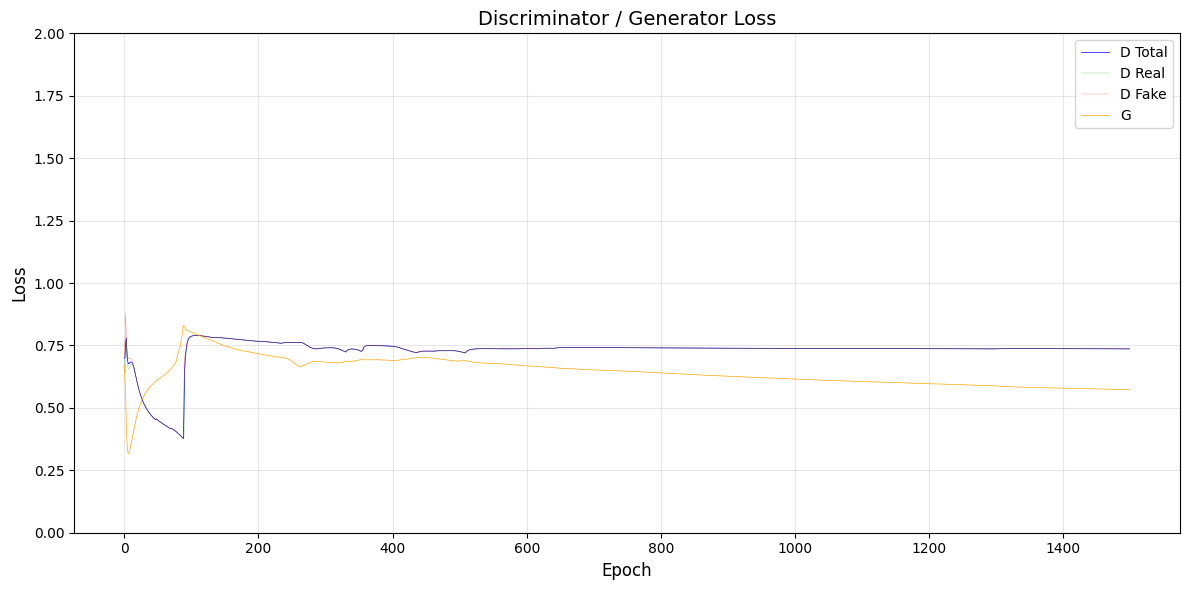

✓ Loss plot saved to ../run/gan/0001_camel/loss_plot.png


In [14]:
# =============================================================================
# PLOT 1: DISCRIMINATOR / GENERATOR LOSS VS EPOCH
# =============================================================================
# Visualizes how both networks'' losses evolve during training.
# Ideally, both should converge to a stable equilibrium.

fig, ax = plt.subplots(figsize=(12, 6))

# Plot discriminator losses
ax.plot(
    [x[0] for x in gan.d_losses],
    color='blue', linewidth=0.5, label='D Total'
)
ax.plot(
    [x[1] for x in gan.d_losses],
    color='green', linewidth=0.25, alpha=0.6, label='D Real'
)
ax.plot(
    [x[2] for x in gan.d_losses],
    color='red', linewidth=0.25, alpha=0.6, label='D Fake'
)

# Plot generator loss
ax.plot(
    [x[0] for x in gan.g_losses],
    color='orange', linewidth=0.5, label='G'
)

# Configure plot
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)
ax.set_title('Discriminator / Generator Loss', fontsize=14)
ax.legend(loc='upper right')
ax.set_ylim(0, 2)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(RUN_FOLDER, 'loss_plot.png'), dpi=200, bbox_inches='tight')
plt.show()
print(f"✓ Loss plot saved to {RUN_FOLDER}/loss_plot.png")

### Plot 2: Discriminator / Generator Accuracy

This plot shows classification accuracy over epochs:
- **D Total (blue)**: Overall discriminator accuracy
- **D Real (green)**: Accuracy on real images (should stay high initially)
- **D Fake (red)**: Accuracy on fake images (decreases as generator improves)
- **G (orange)**: Rate at which generator fools the discriminator

Ideal behavior:
- D Total stabilizes around 50% (discriminator cannot distinguish real from fake)
- G accuracy increases as training progresses

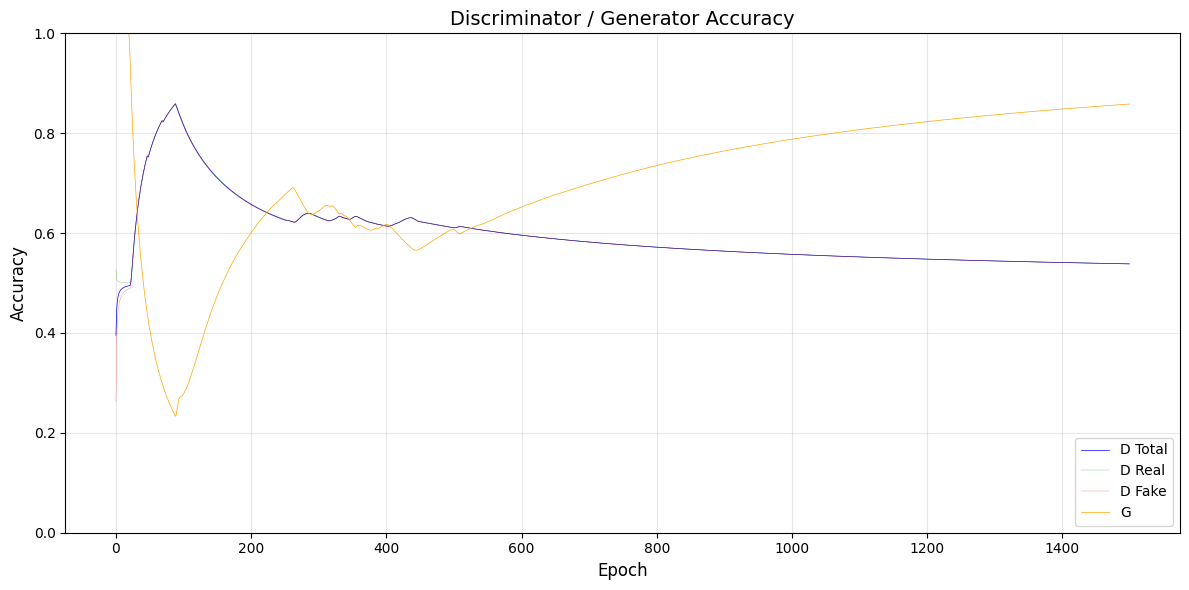

✓ Accuracy plot saved to ../run/gan/0001_camel/accuracy_plot.png


In [15]:
# =============================================================================
# PLOT 2: DISCRIMINATOR / GENERATOR ACCURACY VS EPOCH
# =============================================================================
# Shows how well each network performs its classification task.
# Ideally, discriminator accuracy converges to 50% (random guessing).

fig, ax = plt.subplots(figsize=(12, 6))

# Plot discriminator accuracies
ax.plot(
    [x[3] for x in gan.d_losses],
    color='blue', linewidth=0.5, label='D Total'
)
ax.plot(
    [x[4] for x in gan.d_losses],
    color='green', linewidth=0.25, alpha=0.6, label='D Real'
)
ax.plot(
    [x[5] for x in gan.d_losses],
    color='red', linewidth=0.25, alpha=0.6, label='D Fake'
)

# Plot generator accuracy
ax.plot(
    [x[1] for x in gan.g_losses],
    color='orange', linewidth=0.5, label='G'
)

# Configure plot
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Discriminator / Generator Accuracy', fontsize=14)
ax.legend(loc='lower right')
ax.set_ylim(0, 1)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(RUN_FOLDER, 'accuracy_plot.png'), dpi=200, bbox_inches='tight')
plt.show()
print(f"✓ Accuracy plot saved to {RUN_FOLDER}/accuracy_plot.png")

### Plot 3: Learning Rate Schedule

This plot shows the learning rate decay over epochs (log scale):
- **Discriminator LR (blue)**: Learning rate for the discriminator
- **Generator LR (orange)**: Learning rate for the generator

Step decay is applied to gradually reduce learning rates, helping:
- Stabilize training in later epochs
- Fine-tune the models for better convergence

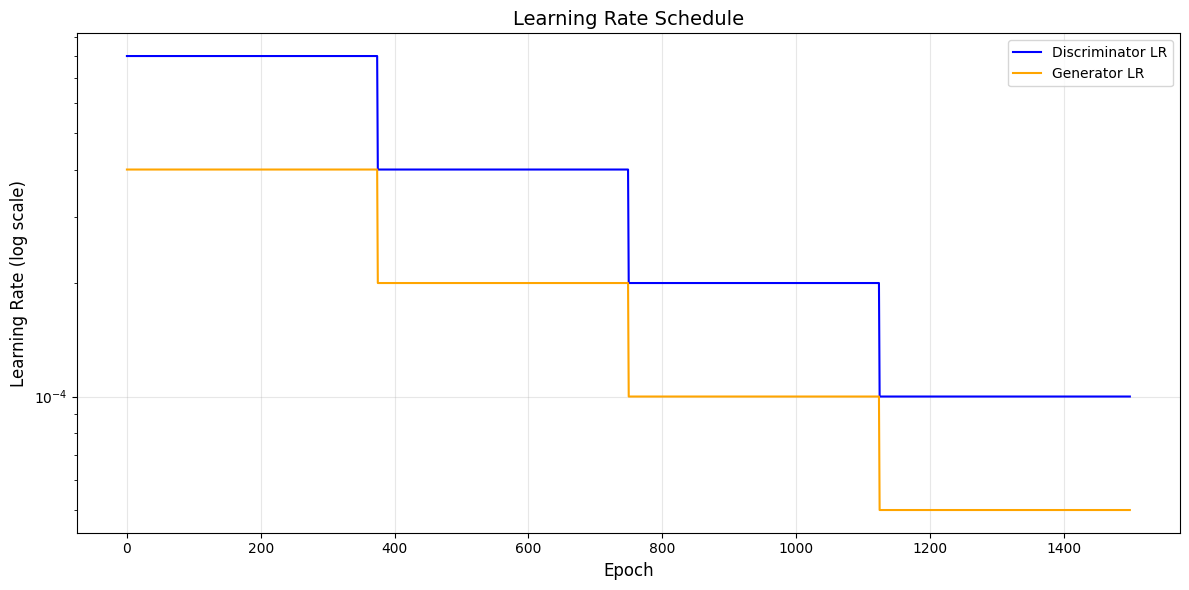

✓ Learning rate plot saved to ../run/gan/0001_camel/lr_schedule_plot.png


In [16]:
# =============================================================================
# PLOT 3: LEARNING RATE SCHEDULE (LOG SCALE)
# =============================================================================
# Displays the step decay learning rate schedule for both networks.
# Using log scale to better visualize the exponential decay pattern.

fig, ax = plt.subplots(figsize=(12, 6))

# Plot learning rates on log scale
ax.semilogy(
    gan.d_lr_history,
    color='blue', linewidth=1.5, label='Discriminator LR'
)
ax.semilogy(
    gan.g_lr_history,
    color='orange', linewidth=1.5, label='Generator LR'
)

# Configure plot
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Learning Rate (log scale)', fontsize=12)
ax.set_title('Learning Rate Schedule', fontsize=14)
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(RUN_FOLDER, 'lr_schedule_plot.png'), dpi=200, bbox_inches='tight')
plt.show()
print(f"✓ Learning rate plot saved to {RUN_FOLDER}/lr_schedule_plot.png")

In [17]:
# =============================================================================
# TRAINING SUMMARY
# =============================================================================
# Print final training metrics

print(f"\n{'═' * 60}")
print("TRAINING COMPLETE")
print(f"{'═' * 60}")
print(f"  Epochs trained  : {gan.epoch}")
print(f"  Final D loss    : {gan.d_losses[-1][0]:.4f}")
print(f"  Final G loss    : {gan.g_losses[-1][0]:.4f}")
print(f"  Final D accuracy: {gan.d_losses[-1][3]:.4f}")
print(f"  Final G accuracy: {gan.g_losses[-1][1]:.4f}")
print(f"  Final D LR      : {gan.d_lr_history[-1]:.2e}")
print(f"  Final G LR      : {gan.g_lr_history[-1]:.2e}")
print(f"  Weights saved   : {RUN_FOLDER}/weights/")
print(f"{'═' * 60}")


════════════════════════════════════════════════════════════
TRAINING COMPLETE
════════════════════════════════════════════════════════════
  Epochs trained  : 1500
  Final D loss    : 0.7362
  Final G loss    : 0.5730
  Final D accuracy: 0.5383
  Final G accuracy: 0.8584
  Final D LR      : 1.00e-04
  Final G LR      : 5.00e-05
  Weights saved   : ../run/gan/0001_camel/weights/
════════════════════════════════════════════════════════════


## Triage Experiment Log

### 📌 Reference Run (GitHub)
| Run | W&B | Config |
|-----|-----|--------|
| gan-camel-bs1024 | [uexhdo3y](https://wandb.ai/cataluna84/generative-deep-learning/runs/uexhdo3y) | BS=1024, dropout=0.4 |

---

### Phase 1-2: dropout=0.2 (❌ All Collapsed)
| Config | Seeds | Peak D Acc | Result |
|--------|-------|------------|--------|
| BS=1024 | 42,123,404,707,1024 | ~56% | ❌ Collapse |
| BS=512 | 42, 1024 | ~56% | ❌ Collapse |

---

### Phase 3: dropout=0.4 (✅ All Success)

| W&B | Seed | BS | Peak D Acc | Final D Acc | Final G Acc | Result |
|-----|------|----|------------|-------------|-------------|--------|
| [6b27357n](https://wandb.ai/cataluna84/generative-deep-learning/runs/6b27357n) | 404 | 512 | **72.2%** | 51.2% | 95.9% | ✅ Success |
| [07vsq1ga](https://wandb.ai/cataluna84/generative-deep-learning/runs/07vsq1ga) | 1024 | 512 | **91.6%** | 53.5% | 90.1% | ✅ Success |
| - | 42 | 512 | 69.6% | 51.7% | 92.0% | ✅ Success |
| [brzdilqv](https://wandb.ai/cataluna84/generative-deep-learning/runs/brzdilqv) | 707 | 512 | **62.5%** | 53.8% | 85.8% | ✅ Success |

---

### 🔬 Key Findings
1. **dropout=0.4 is critical** - all 4 seeds successful
2. **dropout=0.2 causes collapse** - all seeds failed
3. **Best seed: 1024** (91.6% peak D Acc)
4. **Stable convergence confirmed**: D loss ~0.736 (near optimal -log(0.5)≈0.693), balanced R/F losses
5. **No mode collapse**: Generator beats discriminator without causing collapse

## Cleanup

Finish W&B run and optionally restart kernel to release GPU memory.

In [18]:
# =============================================================================
# W&B CLEANUP
# =============================================================================
# Finish the W&B run to ensure all data is synced

wandb.finish()
print("✓ W&B run finished and synced")

d_acc,▁▅▆▇█▇▆▅▅▄▄▃▃▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁
d_acc_fake,▁▁▂██▇▇▆▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
d_acc_real,▁▄▅██▅▄▄▄▄▄▄▄▄▄▃▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
d_loss,▆▄▂▂▁███▇▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
d_loss_fake,▃▂▁▁▁███████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
d_loss_real,▅▃▂▂▁█████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
d_lr,█████████████▄▄▄▄▄▄▄▄▄▄▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▆▆▆▆▆▆▇▇▇▇████
g_acc,█▁▁▅▅▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇
g_loss,▁▄█▇▇▆▆▆▆▆▆▆▆▇▆▆▆▆▆▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅▄▄▄▄▄▄
+1,...


✓ W&B run finished and synced


In [19]:
# =============================================================================
# CLEANUP: Restart Kernel to Release GPU Memory
# =============================================================================
# TensorFlow/CUDA does not release GPU memory within a running Python process.
# Restarting the kernel is the only guaranteed way to free all GPU resources.
#
# ⚠️ WARNING: This will clear all variables and outputs!
# Only run after all work is complete and saved.

# import IPython
# print("Restarting kernel to release GPU memory...")
# IPython.Application.instance().kernel.do_shutdown(restart=True)